# Final Project: Universal Studios Text

In [1]:
pip install plotly

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install textblob

Note: you may need to restart the kernel to use updated packages.


In [4]:
import numpy as np
import pandas as pd
import seaborn as sns


import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_selection import chi2, SelectKBest 
from sklearn.linear_model import Perceptron
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

import re
import string
import scipy.sparse

import plotly.express as px
import plotly.graph_objects as go

from wordcloud import WordCloud, STOPWORDS , ImageColorGenerator
from textblob import TextBlob

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.datasets import fetch_20newsgroups

from sklearn.decomposition import NMF

from time import time
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.datasets import fetch_20newsgroups


## Data Preprocessing

In [5]:
universal = pd.read_csv('/Users/linanguyen/Desktop/universal_studio_branches.csv')
universal.head()

,reviewer,rating,written_date,title,review_text,branch
0,Kelly B,2.0,"May 30, 2021",Universal is a complete Disaster - stick with ...,We went to Universal over Memorial Day weekend...,Universal Studios Florida
1,Jon,1.0,"May 30, 2021",Food is hard to get.,The food service is horrible. I’m not reviewin...,Universal Studios Florida
2,Nerdy P,2.0,"May 30, 2021",Disappointed,I booked this vacation mainly to ride Hagrid m...,Universal Studios Florida
3,ran101278,4.0,"May 29, 2021",My opinion,When a person tries the test seat for the ride...,Universal Studios Florida
4,tammies20132015,5.0,"May 28, 2021",The Bourne Stuntacular...MUST SEE,"Ok, I can't stress enough to anyone and everyo...",Universal Studios Florida


In [6]:
universal_df=universal

universal_df.isnull().sum()

reviewer        0
rating          0
written_date    0
title           0
review_text     0
branch          0
dtype: int64

In [7]:
universal_df.nunique()

reviewer        44086
rating              5
written_date     4276
title           37522
review_text     50847
branch              3
dtype: int64

In [8]:
universal_df.dtypes

reviewer         object
rating          float64
written_date     object
title            object
review_text      object
branch           object
dtype: object

In [9]:
universal_df['branch']=universal_df['branch'].astype('category')

In [10]:
universal_df.dtypes

reviewer          object
rating           float64
written_date      object
title             object
review_text       object
branch          category
dtype: object

In [11]:
# now to convert the written date to an actual date

universal_df['written_date'] = pd.to_datetime(universal_df['written_date'])


universal_df.dtypes # now we will be able to look at different time periods of our choosing

reviewer                object
rating                 float64
written_date    datetime64[ns]
title                   object
review_text             object
branch                category
dtype: object

In [12]:
n_samples = 50904
n_features = 1000
n_components = 10
n_top_words = 20

## EDA

Text(0.5, 1.0, 'Frequency of Universal Studio Ratings')

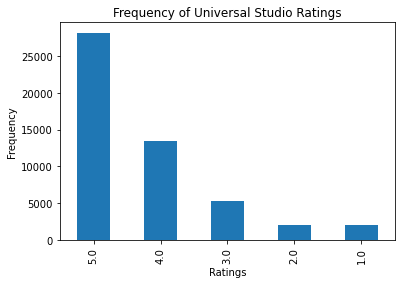

In [13]:
#frequency of ratings

rating = universal['rating']
fig, ax = plt.subplots()
rating.value_counts().plot(ax=ax, kind = 'bar')
plt.xlabel('Ratings')
plt.ylabel('Frequency')
plt.title('Frequency of Universal Studio Ratings')

In [14]:
rating.value_counts()

5.0    28202
4.0    13514
3.0     5229
2.0     1986
1.0     1973
Name: rating, dtype: int64

In [15]:
#ratings vs date
#breaking data into date, month, and year
universal['written_date'] = pd.to_datetime(universal['written_date'], format = '%Y%m%d')
universal['year'] = pd.DatetimeIndex(universal['written_date']).year
universal['day'] = pd.DatetimeIndex(universal['written_date']).day
universal['month'] = pd.DatetimeIndex(universal['written_date']).month
universal

,reviewer,rating,written_date,title,review_text,branch,year,day,month
0,Kelly B,2.0,2021-05-30,Universal is a complete Disaster - stick with ...,We went to Universal over Memorial Day weekend...,Universal Studios Florida,2021,30,5
1,Jon,1.0,2021-05-30,Food is hard to get.,The food service is horrible. I’m not reviewin...,Universal Studios Florida,2021,30,5
2,Nerdy P,2.0,2021-05-30,Disappointed,I booked this vacation mainly to ride Hagrid m...,Universal Studios Florida,2021,30,5
3,ran101278,4.0,2021-05-29,My opinion,When a person tries the test seat for the ride...,Universal Studios Florida,2021,29,5
4,tammies20132015,5.0,2021-05-28,The Bourne Stuntacular...MUST SEE,"Ok, I can't stress enough to anyone and everyo...",Universal Studios Florida,2021,28,5
...,...,...,...,...,...,...,...,...,...
50899,vinz20,4.0,2010-03-29,I'll Be Back Only If ...,This is my first visit to a Universal Studio t...,Universal Studios Singapore,2010,29,3
50900,betty l,4.0,2010-03-29,Universal Studios Singapore Experience,We finally visited Singapore's very first them...,Universal Studios Singapore,2010,29,3
50901,spoonos65,4.0,2010-03-28,Impressive but not quite finished!,We visited during the first week of its 'soft ...,Universal Studios Singapore,2010,28,3
50902,HeatSeekerWrexham_UK,4.0,2010-03-22,Small but beautifully marked,We visited on the 3rd day of the 'soft' openin...,Universal Studios Singapore,2010,22,3


In [16]:
#view unique year values
print(sorted(universal['year'].unique()))


[2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021]


In [17]:
#break data into year and rating
yearrat = universal[['year', 'rating']]
yearrat

,year,rating
0,2021,2.0
1,2021,1.0
2,2021,2.0
3,2021,4.0
4,2021,5.0
...,...,...
50899,2010,4.0
50900,2010,4.0
50901,2010,4.0
50902,2010,4.0


In [18]:
#count of ratings per year
yearratbreak1 = yearrat.groupby(['year', 'rating']).size().reset_index(name = 'count')
yearratbreak1

,year,rating,count
0,2002,1.0,1
1,2003,4.0,3
2,2003,5.0,4
3,2004,1.0,9
4,2004,2.0,5
...,...,...,...
88,2021,1.0,87
89,2021,2.0,35
90,2021,3.0,29
91,2021,4.0,42


In [19]:
rat1 = yearratbreak1.loc[yearratbreak1['rating'] == 1.0]
rat1

rat1count = [1, 0, 9, 6, 9, 11, 14, 17, 38, 46, 79, 117, 169, 227, 253, 206, 288, 297, 99, 87]

In [20]:
rat2 = yearratbreak1.loc[yearratbreak1['rating'] == 2.0]
rat2

rat2count = [0, 0, 5, 7, 10, 13, 14, 17, 56, 70, 98, 138, 220, 268, 286, 229, 239, 228, 53, 35]

In [21]:
rat3 = yearratbreak1.loc[yearratbreak1['rating'] == 3.0]
rat3

rat3count = [0, 0, 4, 3, 7, 3, 7, 32, 68, 159, 260, 425, 622, 852, 850, 648, 644, 503, 113, 29]

In [22]:
rat4 = yearratbreak1.loc[yearratbreak1['rating'] == 4.0]
rat4

rat4count = [0, 3, 11, 5, 11, 19, 32, 37, 124, 329, 738, 1149, 1574, 2393, 2489, 1848, 1448, 1052, 210, 42]

In [23]:
rat5 = yearratbreak1.loc[yearratbreak1['rating'] == 5.0]
rat5 
rat5count = [0, 4, 28, 19, 23, 34, 27, 66, 128, 394, 1095, 1960, 2867, 5361, 5422, 4212, 3556, 2390, 524, 92]

In [24]:
#ratings per year

year = list(range(2002, 2022, 1))
year1 = pd.DataFrame(year)
year1.columns = ['Year']

In [25]:
#create dataframe for year and rating analysis
rat1countdf = pd.DataFrame(rat1count, columns = ['Rating 1'])
rat2countdf = pd.DataFrame(rat2count, columns = ['Rating 2'])
rat3countdf = pd.DataFrame(rat3count, columns = ['Rating 3'])
rat4countdf = pd.DataFrame(rat4count, columns = ['Rating 4'])
rat5countdf = pd.DataFrame(rat5count, columns = ['Rating 5'])

yearrat = rat1countdf.join(rat2countdf)
yearrat = yearrat.join(rat3countdf)
yearrat = yearrat.join(rat4countdf)
yearrat = yearrat.join(rat5countdf)
yearrat = yearrat.join(year1)
yearrat


,Rating 1,Rating 2,Rating 3,Rating 4,Rating 5,Year
0,1,0,0,0,0,2002
1,0,0,0,3,4,2003
2,9,5,4,11,28,2004
3,6,7,3,5,19,2005
4,9,10,7,11,23,2006
5,11,13,3,19,34,2007
6,14,14,7,32,27,2008
7,17,17,32,37,66,2009
8,38,56,68,124,128,2010
9,46,70,159,329,394,2011


<AxesSubplot:title={'center':'Universal Studios Ratings Per Year Stacked Bar Chart'}, xlabel='Year'>

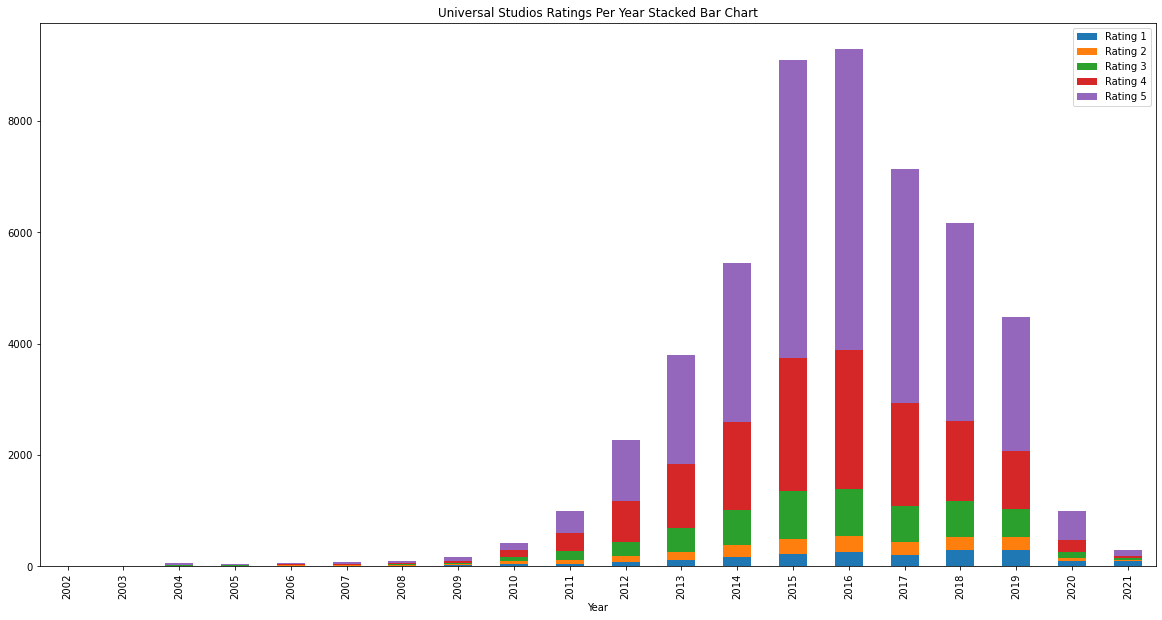

In [26]:
plt.rcParams["figure.figsize"] = (20,10)
yearrat.plot(
    x = 'Year',
    kind = 'bar',
    stacked = True,
    title = 'Universal Studios Ratings Per Year Stacked Bar Chart',
    mark_right = True)

<AxesSubplot:title={'center':'Universal Studios Ratings Per Year Bar Chart'}, xlabel='Year'>

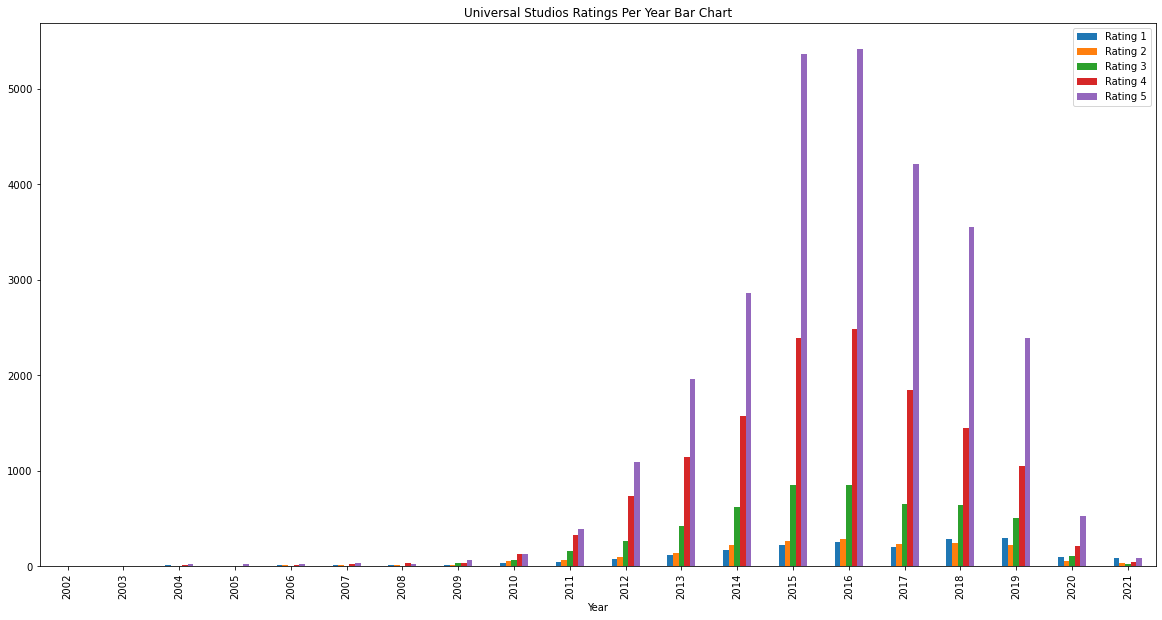

In [27]:
plt.rcParams["figure.figsize"] = (20,10)
yearrat.plot(
    x = 'Year',
    kind = 'bar',
    stacked = False,
    title = 'Universal Studios Ratings Per Year Bar Chart',
    mark_right = True)

In [28]:
#Count of ratings per month
#break data into year and rating
monthrat = universal[['month', 'rating']]
monthrat


,month,rating
0,5,2.0
1,5,1.0
2,5,2.0
3,5,4.0
4,5,5.0
...,...,...
50899,3,4.0
50900,3,4.0
50901,3,4.0
50902,3,4.0


In [29]:
#count of ratings per month
monthratbreak = monthrat.groupby(['month', 'rating']).size().reset_index(name = 'count')
monthratbreak 

,month,rating,count
0,1,1.0,194
1,1,2.0,206
2,1,3.0,534
3,1,4.0,1269
4,1,5.0,2328
5,2,1.0,110
6,2,2.0,124
7,2,3.0,355
8,2,4.0,871
9,2,5.0,1758


In [30]:
#separating ratings per month
ratmonth1 = monthratbreak.loc[monthratbreak['rating'] == 1.0]
ratmonth1


ratmonthcount1 = np.array(ratmonth1['count'])
ratmonthcount1 = pd.DataFrame(ratmonthcount1, columns = ['Rating 1'])
ratmonthcount1

,Rating 1
0,194
1,110
2,162
3,199
4,112
5,109
6,216
7,214
8,120
9,224


In [31]:
ratmonth2 = monthratbreak.loc[monthratbreak['rating'] == 2.0]
ratmonth2

ratmonthcount2 = np.array(ratmonth2['count'])
ratmonthcount2 = pd.DataFrame(ratmonthcount2, columns = ['Rating 2'])
ratmonthcount2

,Rating 2
0,206
1,124
2,152
3,174
4,143
5,155
6,201
7,199
8,144
9,198


In [32]:
ratmonth3 = monthratbreak.loc[monthratbreak['rating'] == 3.0]
ratmonth3

ratmonthcount3 = np.array(ratmonth3['count'])
ratmonthcount3 = pd.DataFrame(ratmonthcount3, columns = ['Rating 3'])
ratmonthcount3

,Rating 3
0,534
1,355
2,420
3,472
4,397
5,371
6,553
7,514
8,374
9,439


In [33]:
ratmonth4 = monthratbreak.loc[monthratbreak['rating'] == 4.0]
ratmonth4

ratmonthcount4 = np.array(ratmonth4['count'])
ratmonthcount4 = pd.DataFrame(ratmonthcount4, columns = ['Rating 4'])
ratmonthcount4

,Rating 4
0,1269
1,871
2,1020
3,1234
4,1050
5,1150
6,1394
7,1302
8,985
9,1185


In [34]:
ratmonth5 = monthratbreak.loc[monthratbreak['rating'] == 5.0]
ratmonth5 

ratmonthcount5 = np.array(ratmonth5['count'])
ratmonthcount5 = pd.DataFrame(ratmonthcount5, columns = ['Rating 5'])
ratmonthcount5

,Rating 5
0,2328
1,1758
2,2191
3,2365
4,2201
5,2482
6,2902
7,2749
8,2463
9,2646


In [35]:
#create month data frame
month = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
months = pd.DataFrame(month)
months.columns = ['Month']
months

,Month
0,January
1,February
2,March
3,April
4,May
5,June
6,July
7,August
8,September
9,October


In [36]:
ratmonthdf = ratmonthcount1.join(ratmonthcount2)
ratmonthdf = ratmonthdf.join(ratmonthcount3)
ratmonthdf = ratmonthdf.join(ratmonthcount4)
ratmonthdf = ratmonthdf.join(ratmonthcount5)
ratmonthdf = ratmonthdf.join(months)
ratmonthdf

ratmonthdf

,Rating 1,Rating 2,Rating 3,Rating 4,Rating 5,Month
0,194,206,534,1269,2328,January
1,110,124,355,871,1758,February
2,162,152,420,1020,2191,March
3,199,174,472,1234,2365,April
4,112,143,397,1050,2201,May
5,109,155,371,1150,2482,June
6,216,201,553,1394,2902,July
7,214,199,514,1302,2749,August
8,120,144,374,985,2463,September
9,224,198,439,1185,2646,October


Text(0, 0.5, 'Frequency')

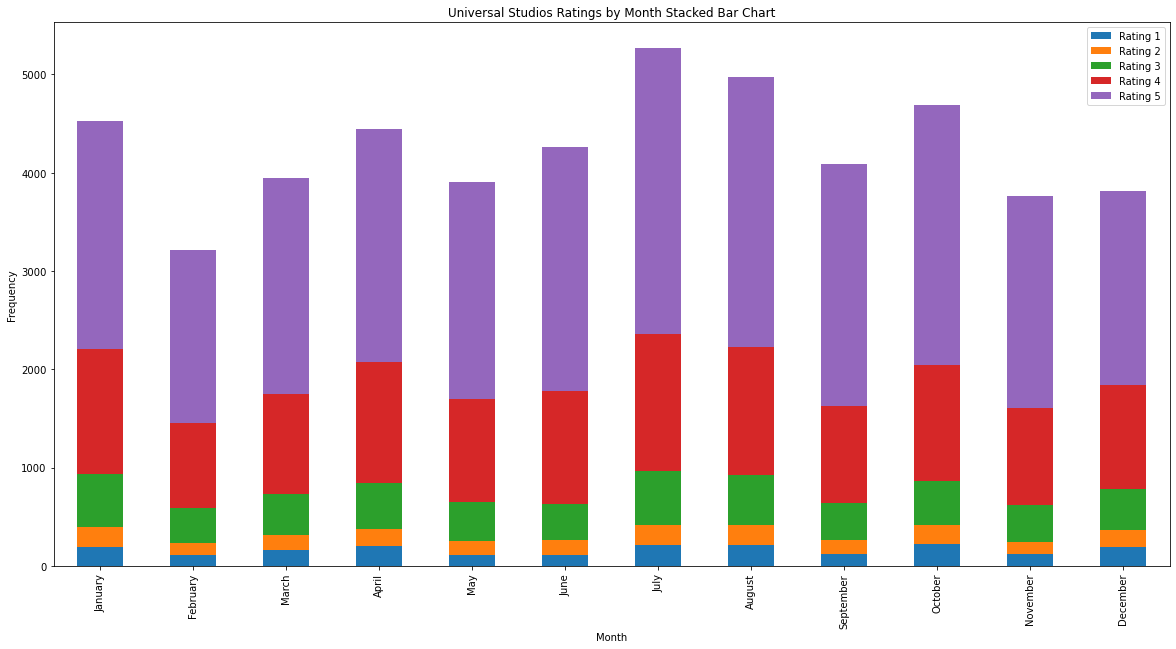

In [37]:
plt.rcParams["figure.figsize"] = (20,10)

ratmonthdf.plot(
 x = 'Month',
    kind = 'bar',
    stacked = True)
plt.title('Universal Studios Ratings by Month Stacked Bar Chart')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

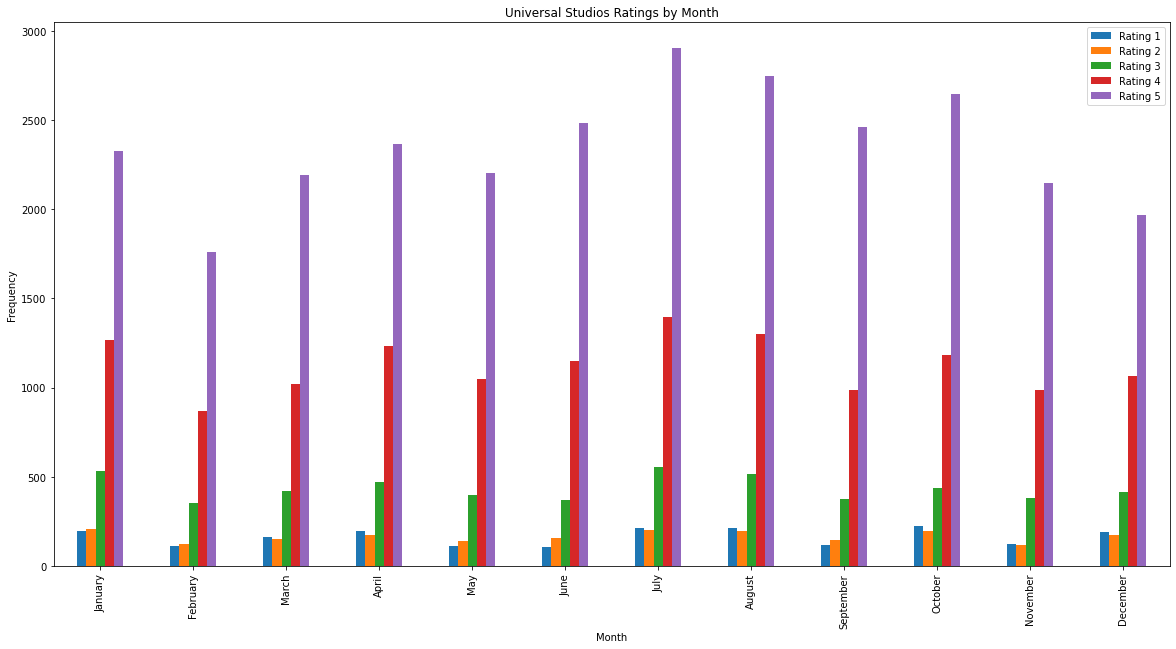

In [38]:
plt.rcParams["figure.figsize"] = (20,10)

ratmonthdf.plot(
    x = 'Month',
    kind = 'bar',
    stacked = False,
    title = 'Stacked Bar Graph',
    mark_right = False)
plt.title('Universal Studios Ratings by Month')
plt.ylabel('Frequency')


In [39]:
#plot Day vs Ratings

dayrat = universal[['day', 'rating']]
dayrat

,day,rating
0,30,2.0
1,30,1.0
2,30,2.0
3,29,4.0
4,28,5.0
...,...,...
50899,29,4.0
50900,29,4.0
50901,28,4.0
50902,22,4.0


In [40]:
#count of ratings per day
dayrat1 = dayrat.groupby(['day', 'rating']).size().reset_index(name = 'count')
dayrat1

,day,rating,count
0,1,1.0,59
1,1,2.0,65
2,1,3.0,158
3,1,4.0,446
4,1,5.0,915
...,...,...,...
150,31,1.0,49
151,31,2.0,41
152,31,3.0,116
153,31,4.0,281


In [41]:
day = list(range(1, 32, 1))
day = pd.DataFrame(day)
day.columns = ['Day']
day

,Day
0,1
1,2
2,3
3,4
4,5
5,6
6,7
7,8
8,9
9,10


In [42]:
ratday1 = dayrat1.loc[dayrat1['rating'] == 1.0]
ratday1

ratday1count = np.array(ratday1['count'])
ratday1count = pd.DataFrame(ratday1count, columns = ['Rating 1'])
ratday1count


,Rating 1
0,59
1,84
2,73
3,74
4,62
5,62
6,79
7,79
8,63
9,55


In [43]:
ratday2 = dayrat1.loc[dayrat1['rating'] == 2.0]
ratday2

ratday2count = np.array(ratday2['count'])
ratday2count = pd.DataFrame(ratday2count, columns = ['Rating 2'])
ratday2count

,Rating 2
0,65
1,67
2,63
3,77
4,51
5,59
6,57
7,67
8,66
9,66


In [44]:
ratday3 = dayrat1.loc[dayrat1['rating'] == 3.0]
ratday3

ratday3count = np.array(ratday3['count'])
ratday3count = pd.DataFrame(ratday3count, columns = ['Rating 3'])
ratday3count

,Rating 3
0,158
1,203
2,172
3,170
4,167
5,169
6,189
7,196
8,167
9,162


In [45]:
ratday4 = dayrat1.loc[dayrat1['rating'] == 4.0]
ratday4

ratday4count = np.array(ratday4['count'])
ratday4count = pd.DataFrame(ratday4count, columns = ['Rating 4'])
ratday4count

,Rating 4
0,446
1,453
2,521
3,444
4,452
5,447
6,462
7,438
8,438
9,454


In [46]:
ratday5 = dayrat1.loc[dayrat1['rating'] == 5.0]
ratday5

ratday5count = np.array(ratday5['count'])
ratday5count = pd.DataFrame(ratday5count, columns = ['Rating 5'])
ratday5count

,Rating 5
0,915
1,924
2,942
3,988
4,936
5,924
6,918
7,928
8,956
9,905


In [47]:
ratdaydf = ratday1count.join(ratday2count)
ratdaydf = ratdaydf.join(ratday3count)
ratdaydf = ratdaydf.join(ratday4count)
ratdaydf = ratdaydf.join(ratday5count)
ratdaydf = ratdaydf.join(day)
ratdaydf


,Rating 1,Rating 2,Rating 3,Rating 4,Rating 5,Day
0,59,65,158,446,915,1
1,84,67,203,453,924,2
2,73,63,172,521,942,3
3,74,77,170,444,988,4
4,62,51,167,452,936,5
5,62,59,169,447,924,6
6,79,57,189,462,918,7
7,79,67,196,438,928,8
8,63,66,167,438,956,9
9,55,66,162,454,905,10


Text(0, 0.5, 'Frequency')

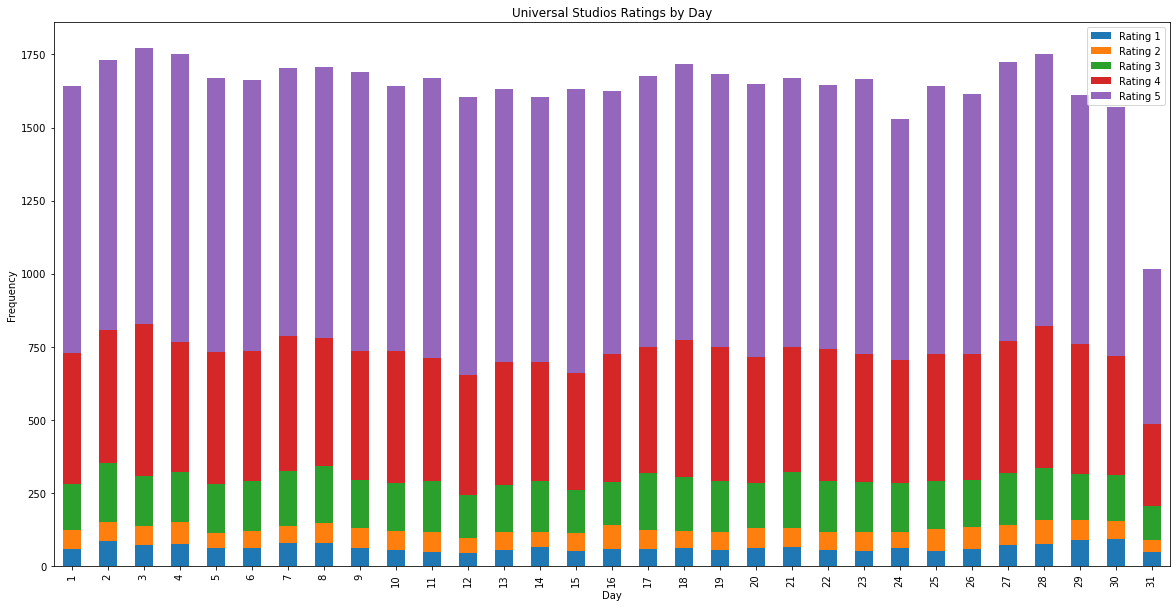

In [48]:
plt.rcParams["figure.figsize"] = (20,10)

ratdaydf.plot(
 x = 'Day',
    kind = 'bar',
    stacked = True)
plt.title('Universal Studios Ratings by Day')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

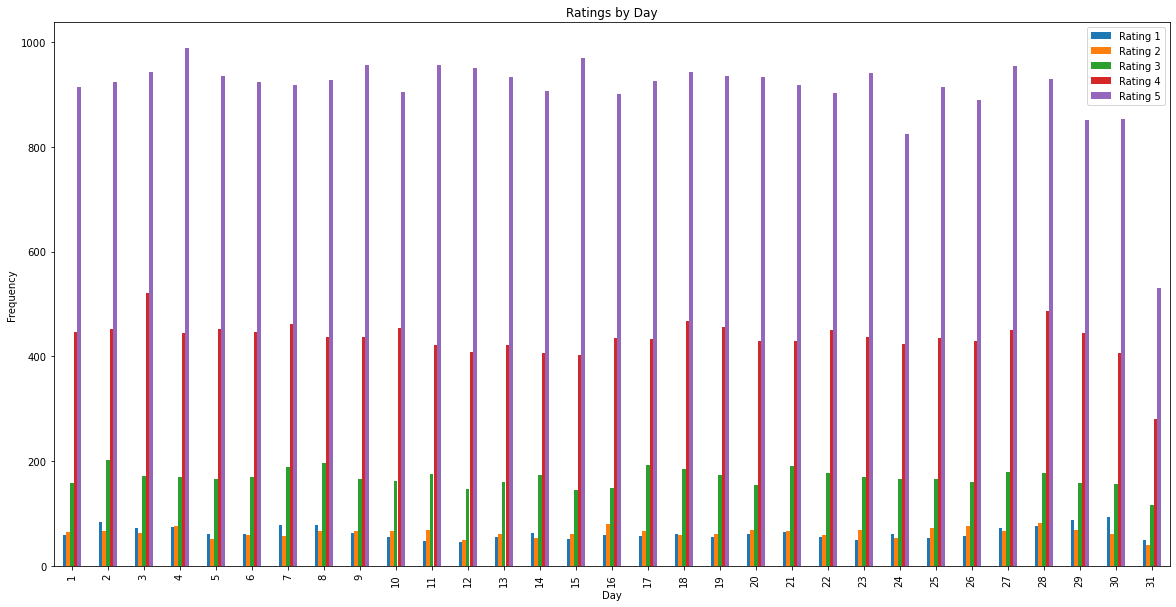

In [49]:
plt.rcParams["figure.figsize"] = (20,10)

ratdaydf.plot(
    x = 'Day',
    kind = 'bar',
    stacked = False,
    title = 'Ratings by Day',
    mark_right = False)
plt.ylabel('Frequency')

In [50]:
#ratings per branch

#break data into year and branch
branchrat = universal[['rating', 'branch', 'year']]
branchrat

,rating,branch,year
0,2.0,Universal Studios Florida,2021
1,1.0,Universal Studios Florida,2021
2,2.0,Universal Studios Florida,2021
3,4.0,Universal Studios Florida,2021
4,5.0,Universal Studios Florida,2021
...,...,...,...
50899,4.0,Universal Studios Singapore,2010
50900,4.0,Universal Studios Singapore,2010
50901,4.0,Universal Studios Singapore,2010
50902,4.0,Universal Studios Singapore,2010


In [51]:
branchrat['branch'].unique()

['Universal Studios Florida', 'Universal Studios Japan', 'Universal Studios Singapore']
Categories (3, object): ['Universal Studios Florida', 'Universal Studios Japan', 'Universal Studios Singapore']

In [52]:
#break data into branches and year
florida = branchrat.loc[branchrat['branch'] == 'Universal Studios Florida']
japan = branchrat.loc[branchrat['branch'] == 'Universal Studios Japan']
singapore = branchrat.loc[branchrat['branch'] == 'Universal Studios Singapore']

In [53]:
florida['rating'].value_counts()

5.0    17978
4.0     6940
3.0     2960
1.0     1374
2.0     1369
Name: rating, dtype: int64

In [54]:
japan['rating'].value_counts()

5.0    2076
4.0    1531
3.0     557
1.0     194
2.0     171
Name: rating, dtype: int64

In [55]:
singapore['rating'].value_counts()

5.0    8148
4.0    5043
3.0    1712
2.0     446
1.0     405
Name: rating, dtype: int64

Text(0.5, 1.0, 'Frequency of Universal Studio Florida Ratings')

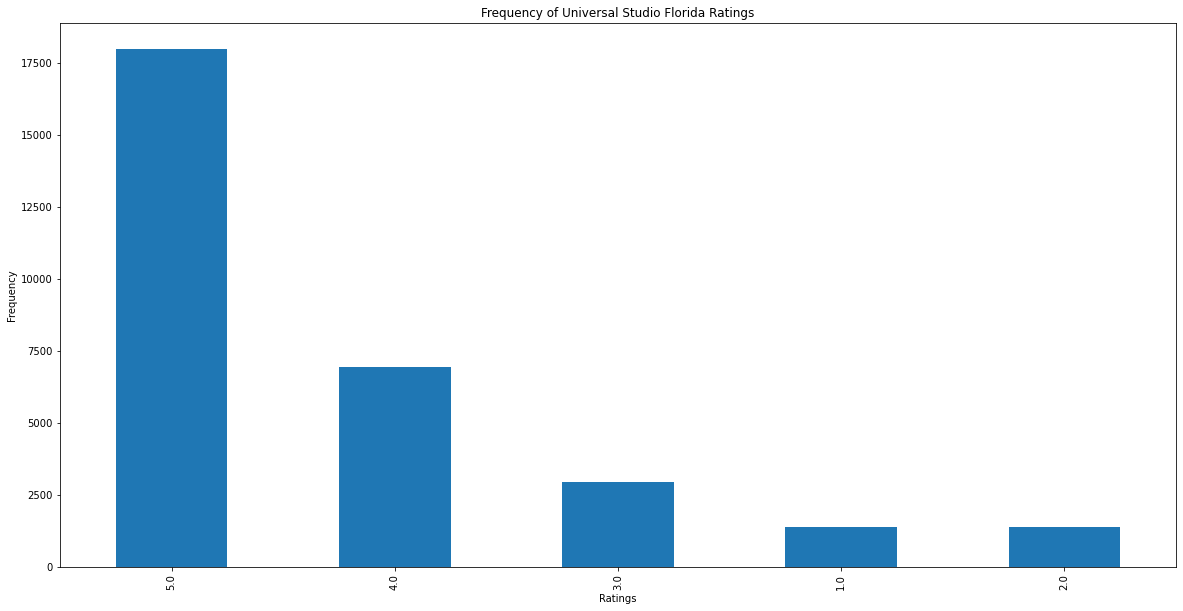

In [56]:
#florida ratings
rating = florida['rating']
fig, ax = plt.subplots()
rating.value_counts().plot(ax=ax, kind = 'bar')
plt.xlabel('Ratings')
plt.ylabel('Frequency')
plt.title('Frequency of Universal Studio Florida Ratings')

Text(0.5, 1.0, 'Frequency of Universal Studio Japan Ratings')

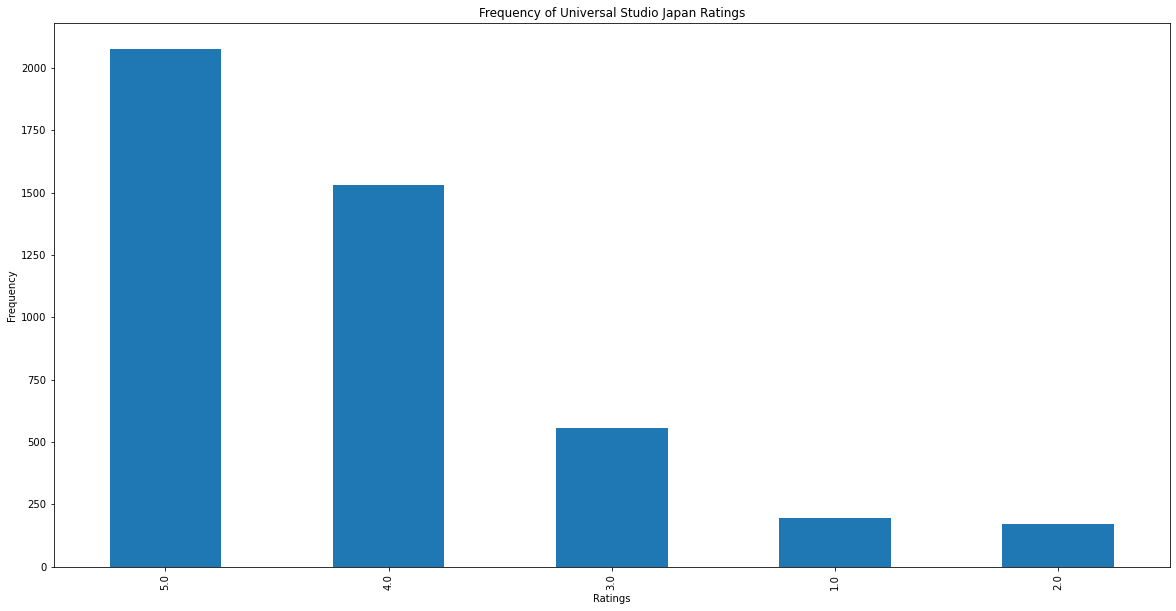

In [57]:
#Japan ratings
rating = japan['rating']
fig, ax = plt.subplots()
rating.value_counts().plot(ax=ax, kind = 'bar')
plt.xlabel('Ratings')
plt.ylabel('Frequency')
plt.title('Frequency of Universal Studio Japan Ratings')

Text(0.5, 1.0, 'Frequency of Universal Studio Singapore Ratings')

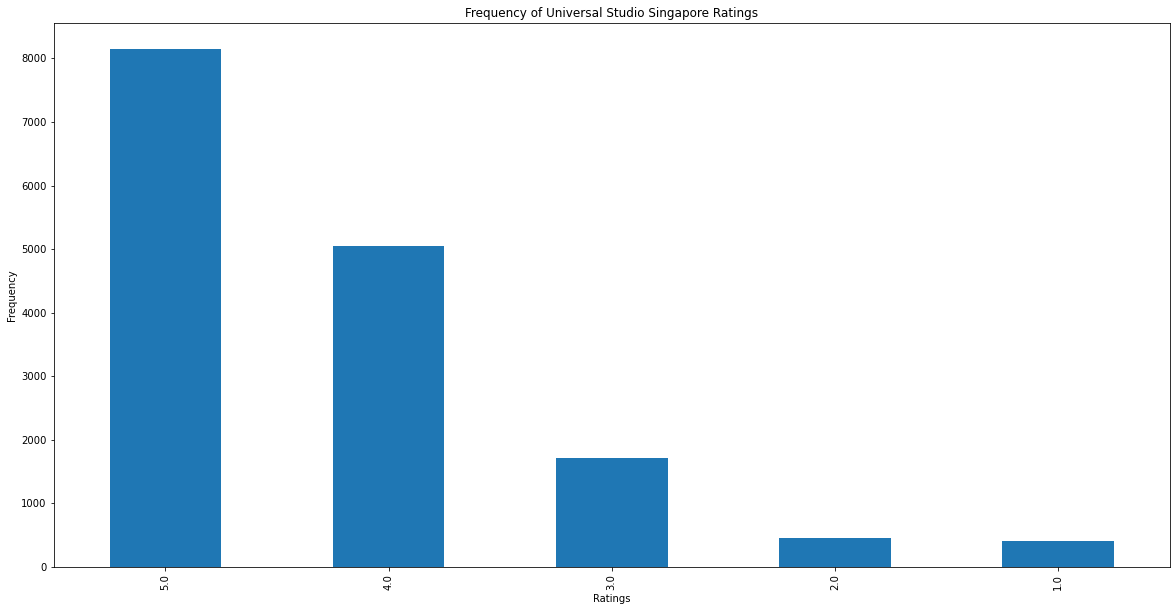

In [58]:
#Singapore ratings
rating = singapore['rating']
fig, ax = plt.subplots()
rating.value_counts().plot(ax=ax, kind = 'bar')
plt.xlabel('Ratings')
plt.ylabel('Frequency')
plt.title('Frequency of Universal Studio Singapore Ratings')

In [59]:
#florida rating per year
florida1 = florida.groupby(['year', 'rating']).size().reset_index(name = 'count')
florida1

,year,rating,count
0,2002,1.0,1
1,2003,4.0,3
2,2003,5.0,4
3,2004,1.0,9
4,2004,2.0,5
...,...,...,...
88,2021,1.0,81
89,2021,2.0,34
90,2021,3.0,26
91,2021,4.0,36


In [60]:
floridarat1 = florida1.loc[florida1['rating'] == 1.0]
floridarat1

floridarat1 = [1,0,9,11,14,17,35,39,64,98,121,140,168,135,190,174,62,81]
floridarat1 = pd.DataFrame(floridarat1, columns = ['Rating 1'])
floridarat1

,Rating 1
0,1
1,0
2,9
3,11
4,14
5,17
6,35
7,39
8,64
9,98


In [61]:
floridarat2 = florida1.loc[florida1['rating'] == 2.0]
floridarat2

floridarat2 = [0,0,5,7,10,13,12,17,42,50,77,108,148,175,192,142,163,132,42,34]
floridarat2 = pd.DataFrame(floridarat2, columns = ['Rating 2'])
floridarat2

,Rating 2
0,0
1,0
2,5
3,7
4,10
5,13
6,12
7,17
8,42
9,50


In [62]:
floridarat3 = florida1.loc[florida1['rating'] == 3.0]
floridarat3

floridarat3 = [0,0,4,3,7,3,7,32,38,73,153,250,334,447,491,357,390,285,59,26]
floridarat3 = pd.DataFrame(floridarat3, columns = ['Rating 3'])
floridarat3

,Rating 3
0,0
1,0
2,4
3,3
4,7
5,3
6,7
7,32
8,38
9,73


In [63]:
floridarat4 = florida1.loc[florida1['rating'] == 4.0]
floridarat4

floridarat4 = [0,3,11,5,11,18,32,36,89,156,271,526,818,1226,1302,968,770,534,128,36]
floridarat4 = pd.DataFrame(floridarat4, columns = ['Rating 4'])
floridarat4

,Rating 4
0,0
1,3
2,11
3,5
4,11
5,18
6,32
7,36
8,89
9,156


In [64]:
floridarat5 = florida1.loc[florida1['rating'] == 5.0]
floridarat5

floridarat5 = [0,4,28,19,23,33,27,66,112,235,473,1054,1866,3583,3465,2698,2418,1450,347,77]
floridarat5 = pd.DataFrame(floridarat5, columns = ['Rating 5'])
floridarat5

,Rating 5
0,0
1,4
2,28
3,19
4,23
5,33
6,27
7,66
8,112
9,235


In [65]:
floridayeardf = floridarat1.join(floridarat2)
floridayeardf = floridayeardf.join(floridarat3)
floridayeardf = floridayeardf.join(floridarat4)
floridayeardf = floridayeardf.join(floridarat5)
floridayeardf = floridayeardf.join(year1)
floridayeardf

,Rating 1,Rating 2,Rating 3,Rating 4,Rating 5,Year
0,1,0,0,0,0,2002
1,0,0,0,3,4,2003
2,9,5,4,11,28,2004
3,11,7,3,5,19,2005
4,14,10,7,11,23,2006
5,17,13,3,18,33,2007
6,35,12,7,32,27,2008
7,39,17,32,36,66,2009
8,64,42,38,89,112,2010
9,98,50,73,156,235,2011


<AxesSubplot:title={'center':'Universal Studios Florida Ratings Per Year Stacked Bar Chart'}, xlabel='Year'>

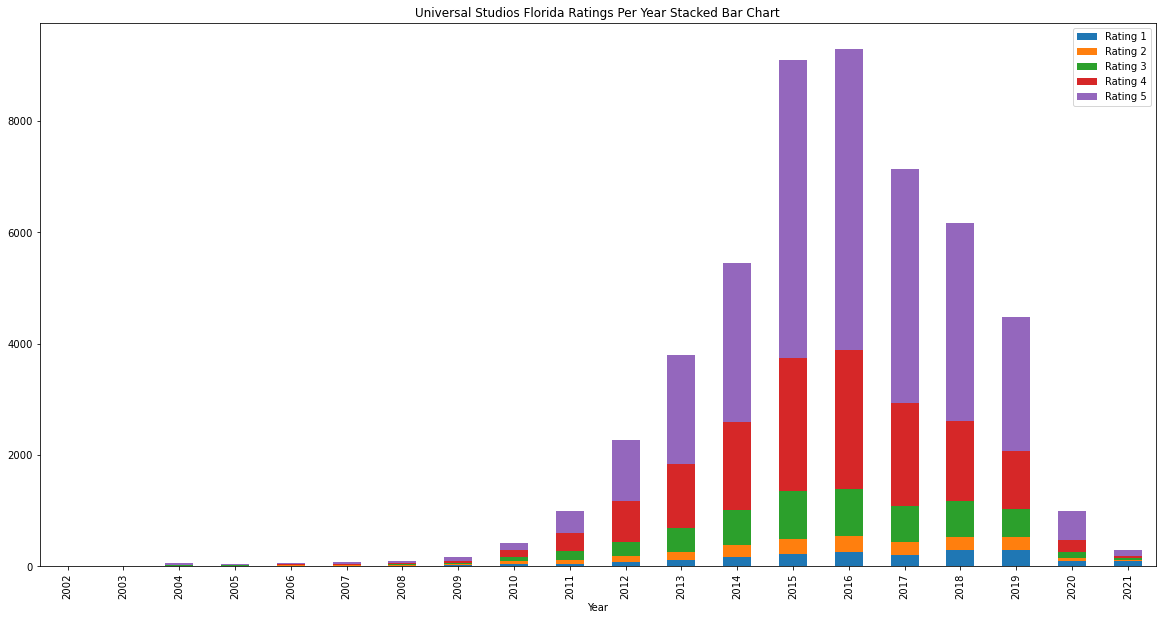

In [66]:
plt.rcParams["figure.figsize"] = (20,10)
yearrat.plot(
    x = 'Year',
    kind = 'bar',
    stacked = True,
    title = 'Universal Studios Florida Ratings Per Year Stacked Bar Chart',
    mark_right = True)

## Supervised Learning

In [67]:
universal_df_text = universal_df[['review_text', 'rating']]
corpus2= universal_df_text['review_text']
y= universal_df_text['rating']

In [68]:
print(corpus2.shape, y.shape)

(50904,) (50904,)


In [69]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()

vectorizer

TfidfVectorizer()

In [70]:
X_matrix = vectorizer.fit_transform(corpus2)
X_matrix.shape

(50904, 42028)

In [71]:
import scipy.sparse

X =pd.DataFrame.sparse.from_spmatrix(X_matrix, columns = vectorizer.get_feature_names())

In [72]:
X

,00,000,0000hrs,000km,000plusy,000s,000y,000yen,00a,00am,...,難捨難離,非常欣賞,音の演出を堪能,音楽の効果もあるのか,頭上だったのですぐには気づかず,餐廳及小食,香港的兩大樂園都是慣例,馬上清潔腿步,１日楽しむことができました,２回乗ってみたものの
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50899,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50900,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50901,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50902,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [73]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [74]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

select_k = SelectKBest(chi2, k=10) # to get my top 10 features
select_X = select_k.fit_transform(X_train, y_train)
select_X.shape

(40723, 10)

In [75]:
from sklearn.feature_extraction.text import CountVectorizer

X_train.columns[select_k.get_support()] 

Index(['amazing', 'customer', 'money', 'not', 'poor', 'refund', 'rude', 'told',
       'waste', 'worst'],
      dtype='object')

Text(0, 0.5, 'Accuracy')

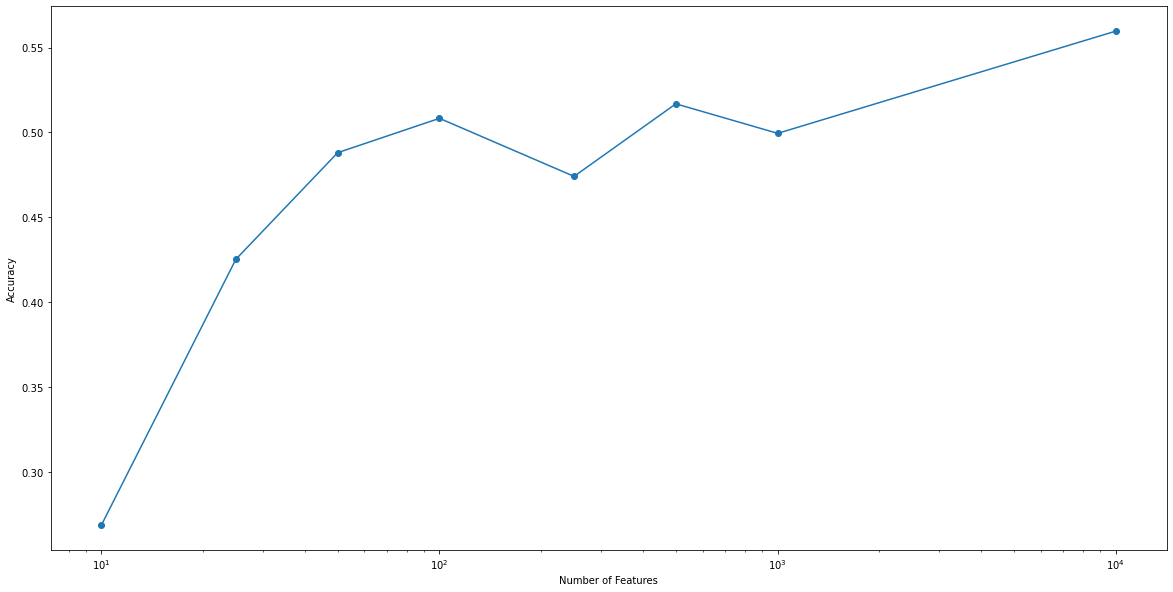

In [76]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import Perceptron


acc=[]
k_vals = [10, 25, 50, 100, 250, 500, 1000, 10000]

for k in k_vals:
    sel = SelectKBest(chi2, k=k)
    X_train_new2 = sel.fit_transform(X_train, y_train)
    X_test_new2 = sel.transform(X_test)
    clf2 = Perceptron(eta0 = 0.1, random_state = 42)
    clf2.fit(X_train_new2, y_train)
    acc.append(clf2.score(X_test_new2, y_test))
    
plt.plot(k_vals, acc, '-o')
plt.xscale('log')
plt.xlabel('Number of Features')
plt.ylabel('Accuracy')

## WordCloud

In [77]:
from wordcloud import WordCloud, STOPWORDS

In [78]:
word_text = universal_df['review_text'].values
word_strings = "".join(word_text)

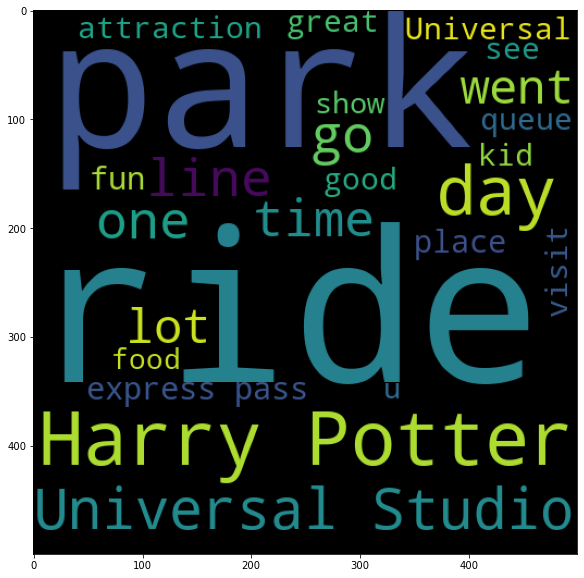

In [79]:
stopwords = set(STOPWORDS)
stopwords.add("SPAM_SPAM")

Universal_WordCloud= WordCloud(width = 500, height = 500, max_words =25, stopwords = stopwords).generate(word_strings)

plt.figure(figsize=(10,10))
plt.imshow(Universal_WordCloud)

## Sklearn NB Multi

[5. 4. 5. ... 5. 5. 5.]
              precision    recall  f1-score   support

         1.0       1.00      0.00      0.01       377
         2.0       0.00      0.00      0.00       412
         3.0       0.67      0.00      0.00      1022
         4.0       0.49      0.01      0.03      2762
         5.0       0.56      1.00      0.71      5608

    accuracy                           0.55     10181
   macro avg       0.54      0.20      0.15     10181
weighted avg       0.54      0.55      0.40     10181



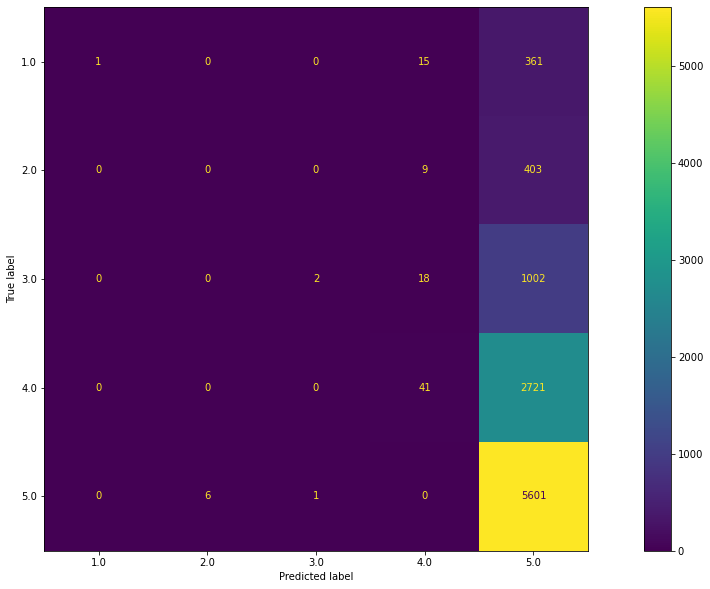

In [80]:
from sklearn.naive_bayes import MultinomialNB

clf = MultinomialNB()

clf.fit(X, y)

y_pred= clf.predict(X_test)

MultinomialNB()

print(clf.predict(X))

acc.append(clf.score(X_test, y_test))

from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(clf, X_test, y_test)

Text(0, 0.5, 'Accuracy')

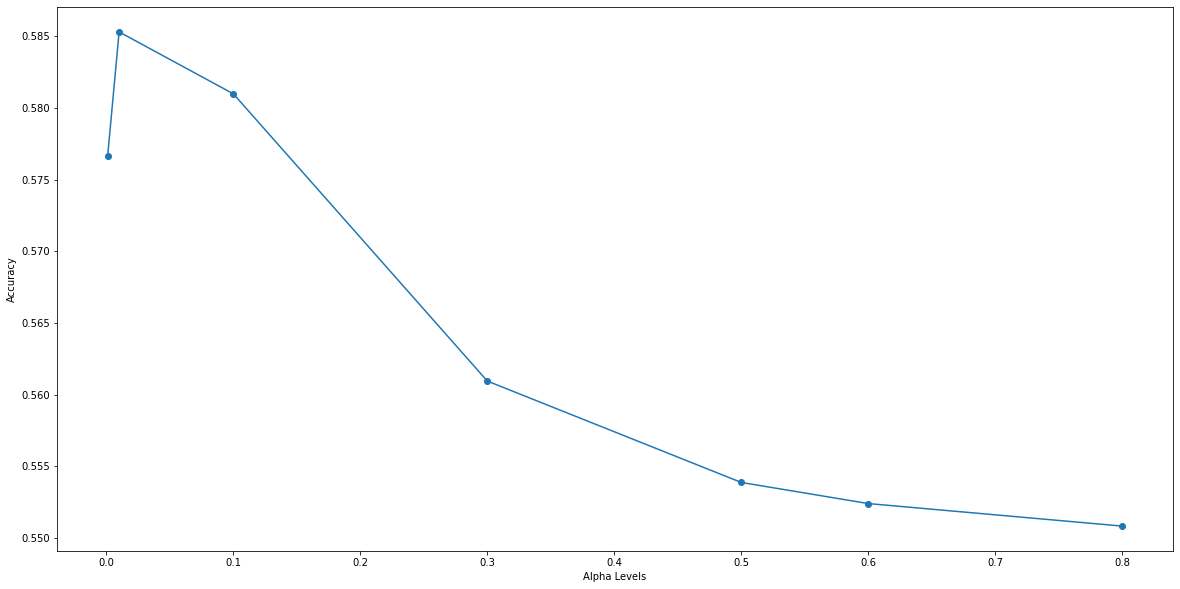

In [81]:
acc=[]
alphas = [0.8, 0.6, 0.5, 0.3, 0.1, 0.010, 0.0010]

for alpha in alphas:
    clf3 = MultinomialNB(alpha = alpha)
    clf3.fit(X_train, y_train)
    acc.append(clf3.score(X_test, y_test))


plt.plot(alphas, acc, '-o')
#plt.xscale('log')
plt.xlabel('Alpha Levels')
plt.ylabel('Accuracy')

## looking at just Universal Orlando Reviews

In [82]:
is_universal_orlando = universal_df['branch']=='Universal Studios Florida'
is_universal_orlando.head()

0    True
1    True
2    True
3    True
4    True
Name: branch, dtype: bool

In [83]:
universal_orlando =universal_df[is_universal_orlando]

universal_orlando.head()

,reviewer,rating,written_date,title,review_text,branch,year,day,month
0,Kelly B,2.0,2021-05-30,Universal is a complete Disaster - stick with ...,We went to Universal over Memorial Day weekend...,Universal Studios Florida,2021,30,5
1,Jon,1.0,2021-05-30,Food is hard to get.,The food service is horrible. I’m not reviewin...,Universal Studios Florida,2021,30,5
2,Nerdy P,2.0,2021-05-30,Disappointed,I booked this vacation mainly to ride Hagrid m...,Universal Studios Florida,2021,30,5
3,ran101278,4.0,2021-05-29,My opinion,When a person tries the test seat for the ride...,Universal Studios Florida,2021,29,5
4,tammies20132015,5.0,2021-05-28,The Bourne Stuntacular...MUST SEE,"Ok, I can't stress enough to anyone and everyo...",Universal Studios Florida,2021,28,5


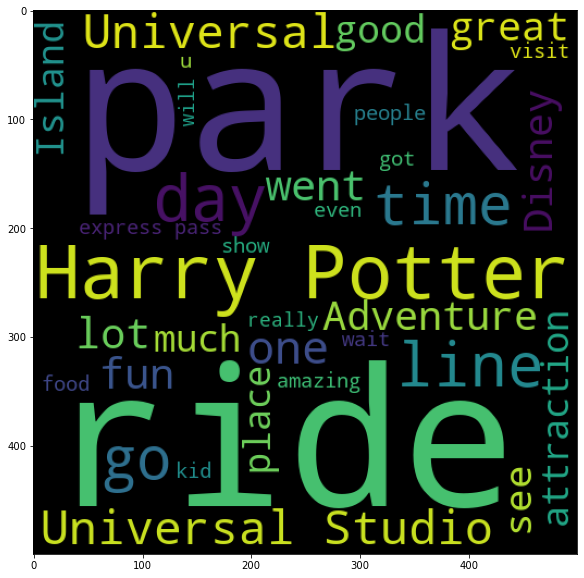

In [84]:
word_text = universal_orlando['review_text'].values
word_strings = "".join(word_text)

stopwords = set(STOPWORDS)
stopwords.add("SPAM_SPAM")

Universal_Orlando_WordCloud= WordCloud(width = 500, height = 500, max_words =35, stopwords = stopwords).generate(word_strings)

plt.figure(figsize=(10,10))
plt.imshow(Universal_Orlando_WordCloud)

Text(0, 0.5, 'Accuracy')

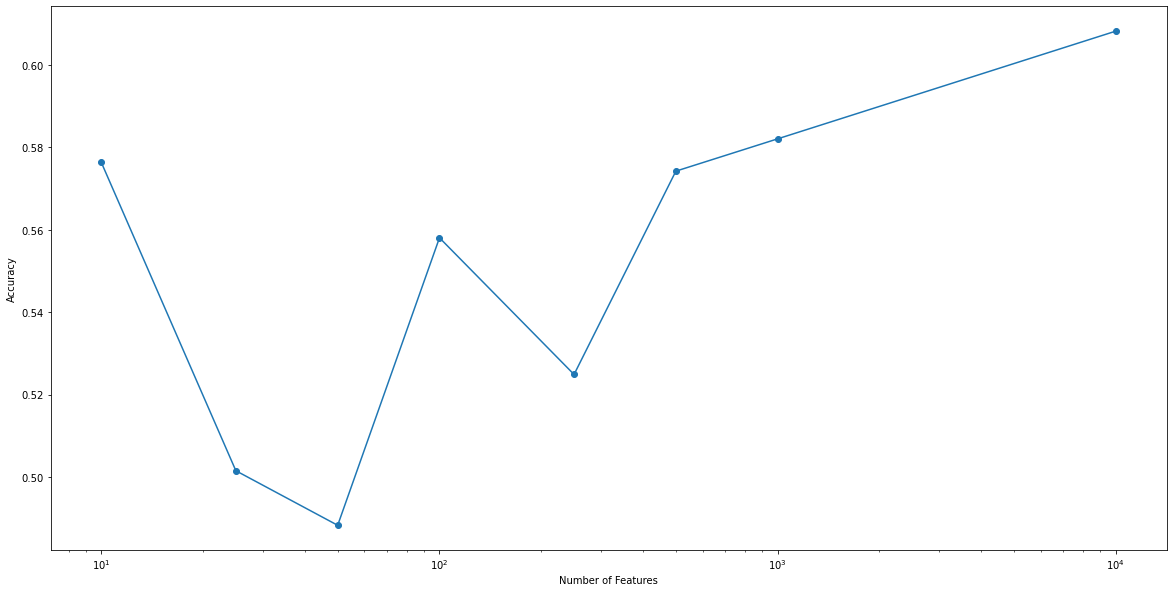

In [85]:
universal_orlando_text = universal_orlando[['review_text', 'rating']]
corpus3= universal_orlando_text['review_text']
y2= universal_orlando_text['rating']

vectorizer = TfidfVectorizer()

vectorizer

X_matrix2 = vectorizer.fit_transform(corpus3)
X_matrix2.shape

X2 =pd.DataFrame.sparse.from_spmatrix(X_matrix2, columns = vectorizer.get_feature_names())

X_train, X_test, y_train, y_test = train_test_split(X2, y2, test_size=0.20, random_state=42)

select_k = SelectKBest(chi2, k=10) # to get my top 10 features
select_X = select_k.fit_transform(X_train, y_train)
select_X.shape

X_train.columns[select_k.get_support()] 

acc=[]
k_vals = [10, 25, 50, 100, 250, 500, 1000, 10000]

for k in k_vals:
    sel = SelectKBest(chi2, k=k)
    X_train_new3 = sel.fit_transform(X_train, y_train)
    X_test_new3 = sel.transform(X_test)
    clf4 = Perceptron(eta0 = 0.1, random_state = 42)
    clf4.fit(X_train_new3, y_train)
    acc.append(clf4.score(X_test_new3, y_test))
    
plt.plot(k_vals, acc, '-o')
plt.xscale('log')
plt.xlabel('Number of Features')
plt.ylabel('Accuracy')

              precision    recall  f1-score   support

         1.0       0.52      0.30      0.38       270
         2.0       0.30      0.09      0.14       259
         3.0       0.31      0.13      0.18       571
         4.0       0.31      0.15      0.20      1393
         5.0       0.67      0.92      0.78      3632

    accuracy                           0.61      6125
   macro avg       0.42      0.32      0.34      6125
weighted avg       0.54      0.61      0.55      6125



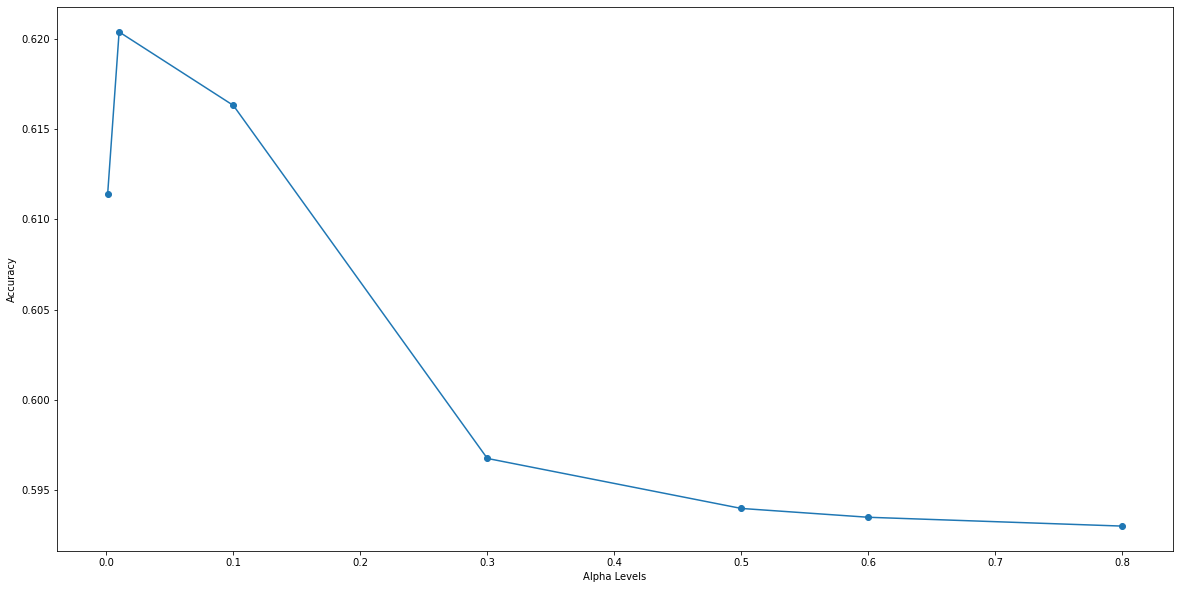

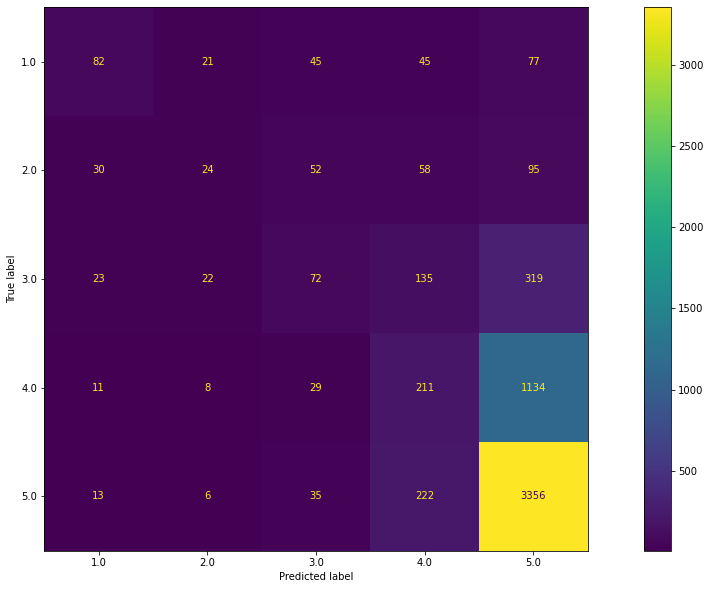

In [86]:
acc=[]
alphas = [0.8, 0.6, 0.5, 0.3, 0.1, 0.010, 0.0010]

for alpha in alphas:
    clf5 = MultinomialNB(alpha = alpha)
    clf5.fit(X_train, y_train)
    acc.append(clf5.score(X_test, y_test))


plt.plot(alphas, acc, '-o')
#plt.xscale('log')
plt.xlabel('Alpha Levels')
plt.ylabel('Accuracy')

y_pred3= clf5.predict(X_test)

print(classification_report(y_test, y_pred3))

plot_confusion_matrix(clf5, X_test, y_test)

## Unsupervised Learning

In [87]:
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx +1}',
                     fontdict={'fontsize': 30})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

In [88]:
t0 = time()
data_samples = corpus2[:n_samples]
print("done in %0.3fs." % (time() - t0))

done in 0.000s.


In [89]:
# Use tf-idf features for NMF.
print("Extracting tf-idf features for NMF...")
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,
                                   max_features=n_features,
                                   stop_words='english')
t0 = time()
tfidf = tfidf_vectorizer.fit_transform(data_samples)
print("done in %0.3fs." % (time() - t0))

Extracting tf-idf features for NMF...
done in 2.780s.


In [90]:
# Use tf (raw term count) features for LDA.
print("Extracting tf features for LDA...")
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2,
                                max_features=n_features,
                                stop_words='english')
t0 = time()
tf = tf_vectorizer.fit_transform(data_samples)
print("done in %0.3fs." % (time() - t0))
print()

Extracting tf features for LDA...
done in 2.730s.



Fitting the NMF model (Frobenius norm) with tf-idf features, n_samples=50904 and n_features=1000...


/Users/linanguyen/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "
/Users/linanguyen/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


done in 4.027s.


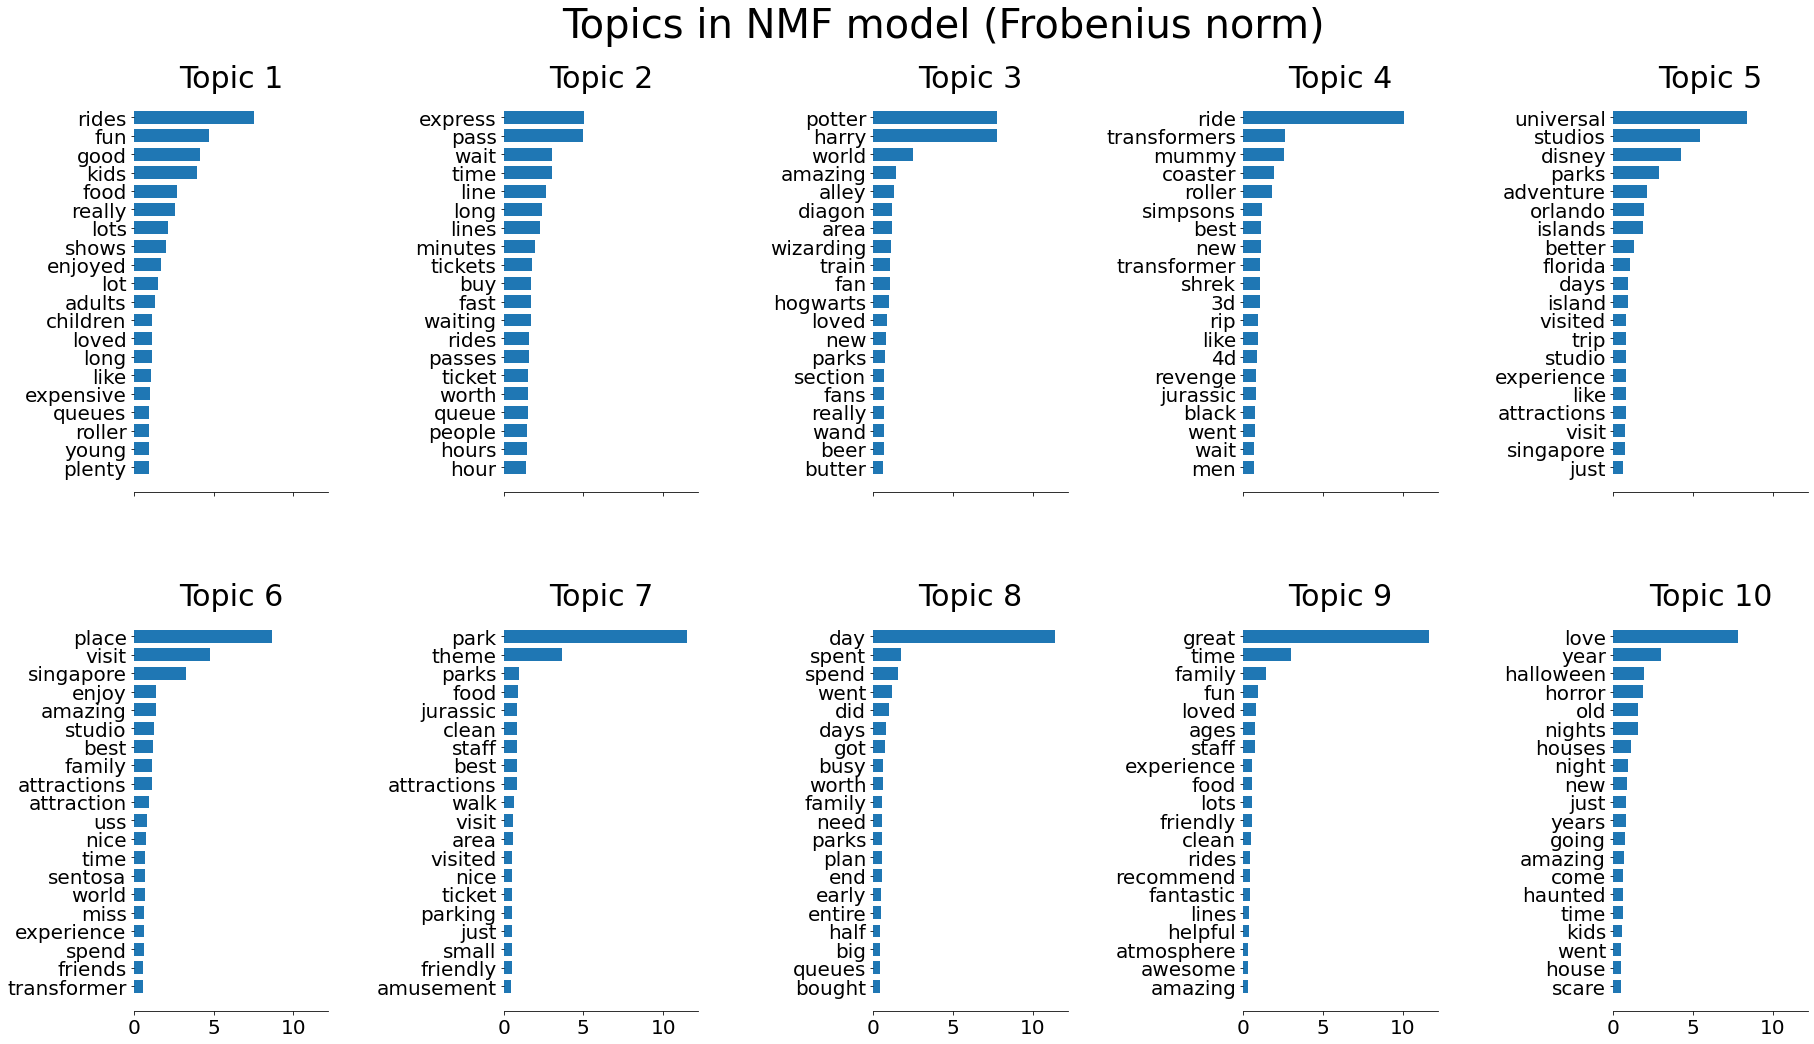

In [91]:
# Fit the NMF model
print("Fitting the NMF model (Frobenius norm) with tf-idf features, "
      "n_samples=%d and n_features=%d..."
      % (n_samples, n_features))
t0 = time()
nmf = NMF(n_components=n_components, random_state=1,
          alpha=.1, l1_ratio=.5).fit(tfidf)
print("done in %0.3fs." % (time() - t0))


tfidf_feature_names = tfidf_vectorizer.get_feature_names()
plot_top_words(nmf, tfidf_feature_names, n_top_words,
               'Topics in NMF model (Frobenius norm)')



 Fitting the NMF model (generalized Kullback-Leibler divergence) with tf-idf features, n_samples=50904 and n_features=1000...


/Users/linanguyen/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


done in 12.116s.


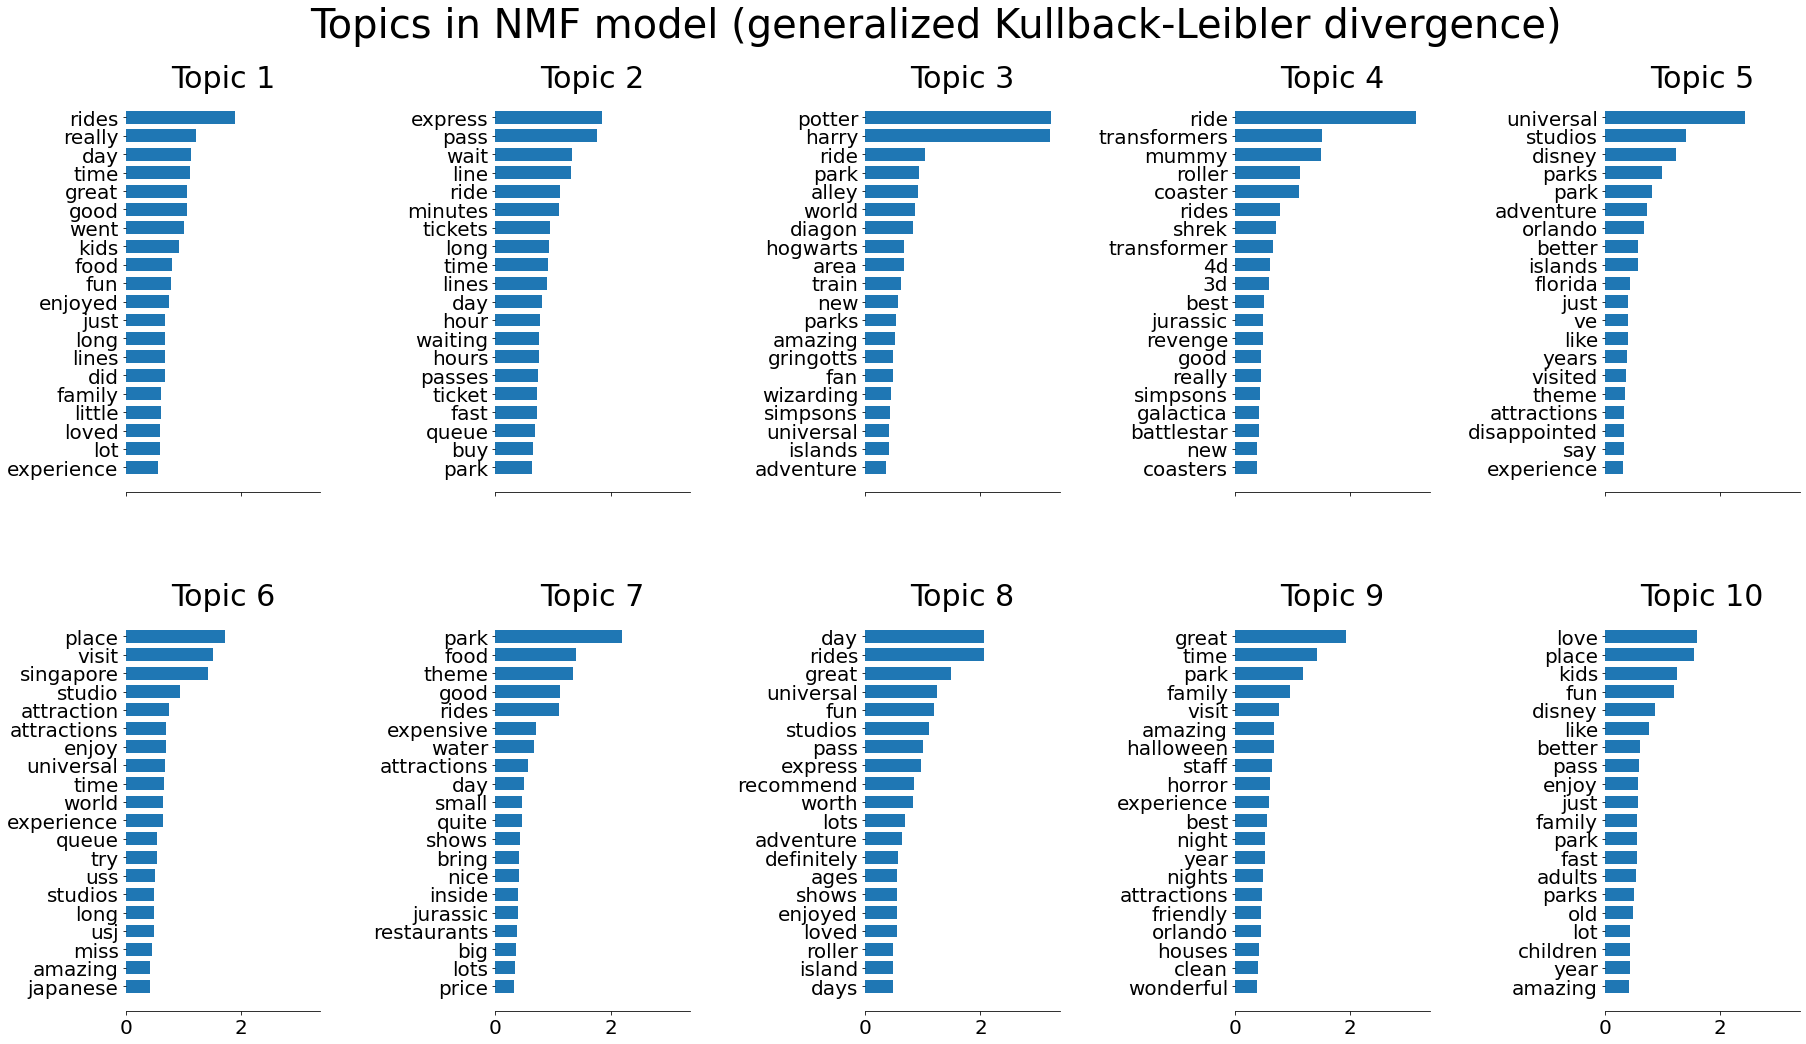



 Fitting LDA models with tf features, n_samples=50904 and n_features=1000...


In [92]:
# Fit the NMF model
print('\n' * 2, "Fitting the NMF model (generalized Kullback-Leibler "
      "divergence) with tf-idf features, n_samples=%d and n_features=%d..."
      % (n_samples, n_features))
t0 = time()
nmf = NMF(n_components=n_components, random_state=1,
          beta_loss='kullback-leibler', solver='mu', max_iter=1000, alpha=.1,
          l1_ratio=.5).fit(tfidf)
print("done in %0.3fs." % (time() - t0))

tfidf_feature_names = tfidf_vectorizer.get_feature_names()
plot_top_words(nmf, tfidf_feature_names, n_top_words,
               'Topics in NMF model (generalized Kullback-Leibler divergence)')

print('\n' * 2, "Fitting LDA models with tf features, "
      "n_samples=%d and n_features=%d..."
      % (n_samples, n_features))

done in 70.312s.


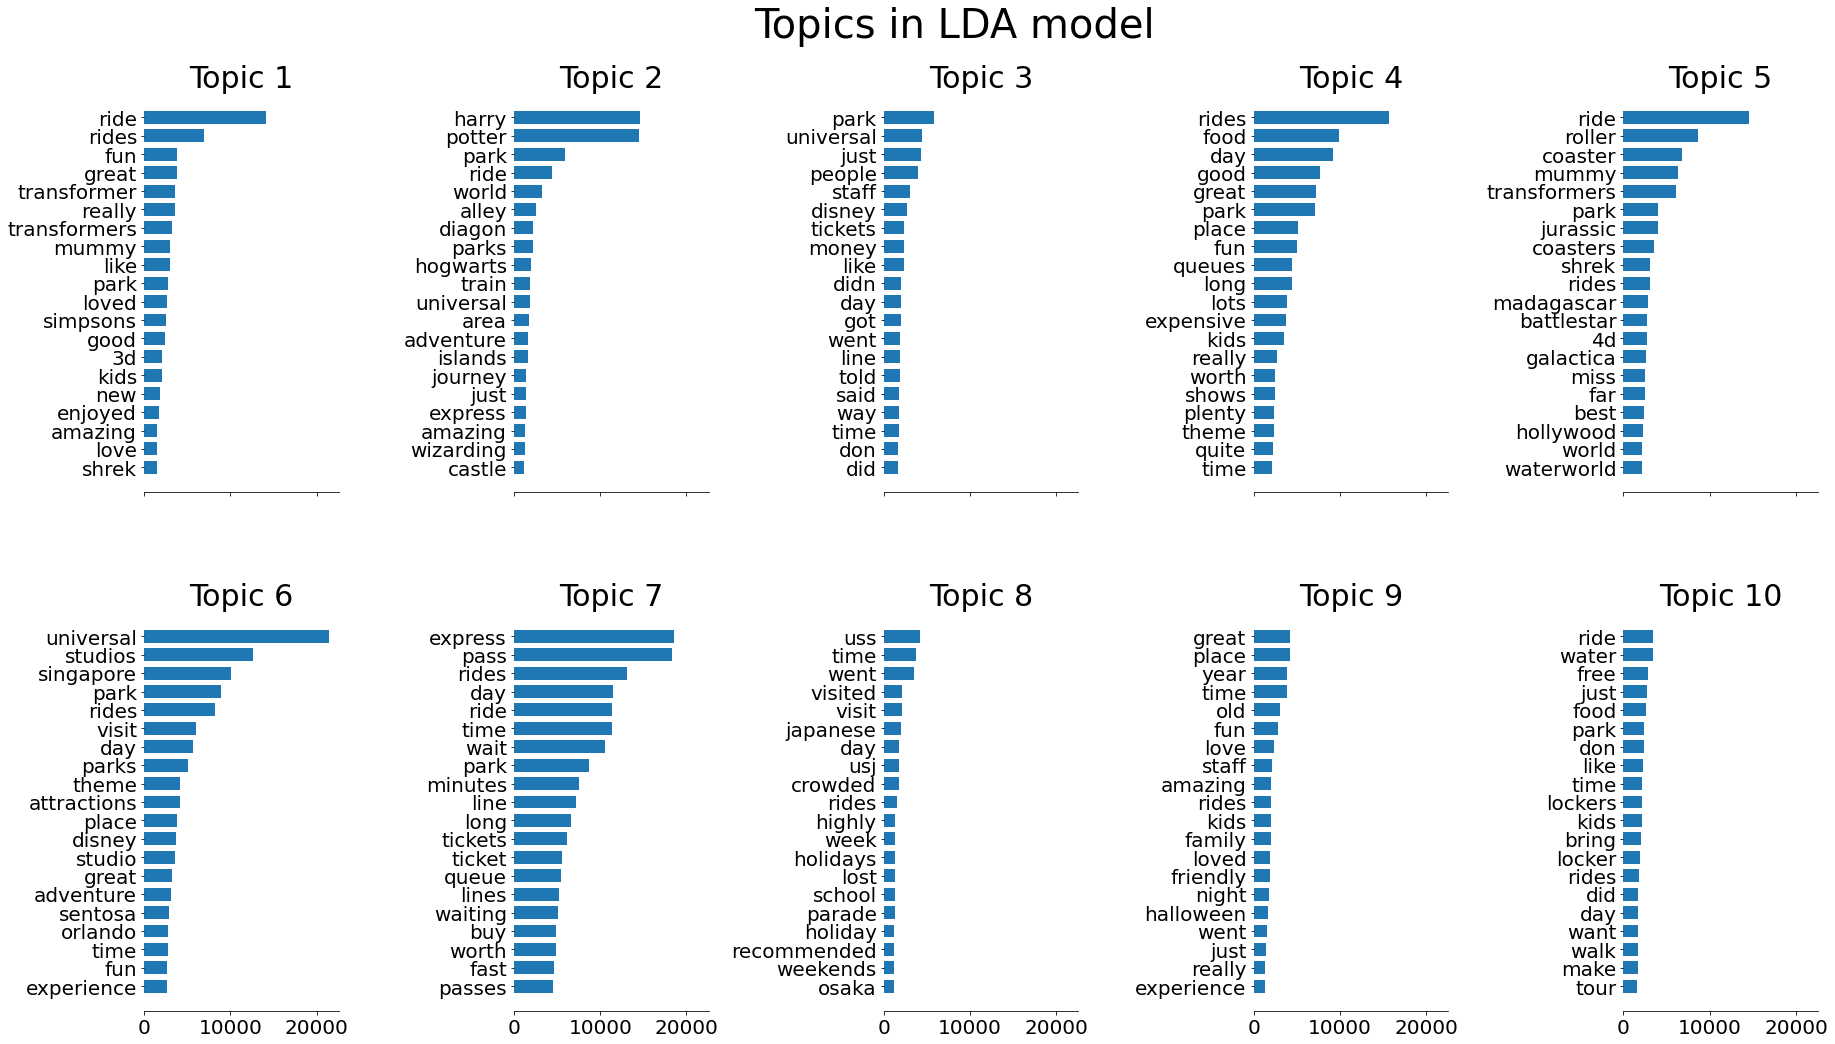

In [93]:
lda = LatentDirichletAllocation(n_components=n_components, max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)
t0 = time()
lda.fit(tf)
print("done in %0.3fs." % (time() - t0))

tf_feature_names = tf_vectorizer.get_feature_names()
plot_top_words(lda, tf_feature_names, n_top_words, 'Topics in LDA model')

In [94]:
# Use tf-idf features for NMF.
print("Extracting tf-idf features for NMF...")
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,
                                   max_features=n_features,
                                   stop_words='english')
t0 = time()
tfidf = tfidf_vectorizer.fit_transform(data_samples)
print("done in %0.3fs." % (time() - t0))

Extracting tf-idf features for NMF...
done in 2.776s.




 Fitting the NMF model (generalized Kullback-Leibler divergence) with tf-idf features, n_samples=50904 and n_features=1000...
done in 12.212s.


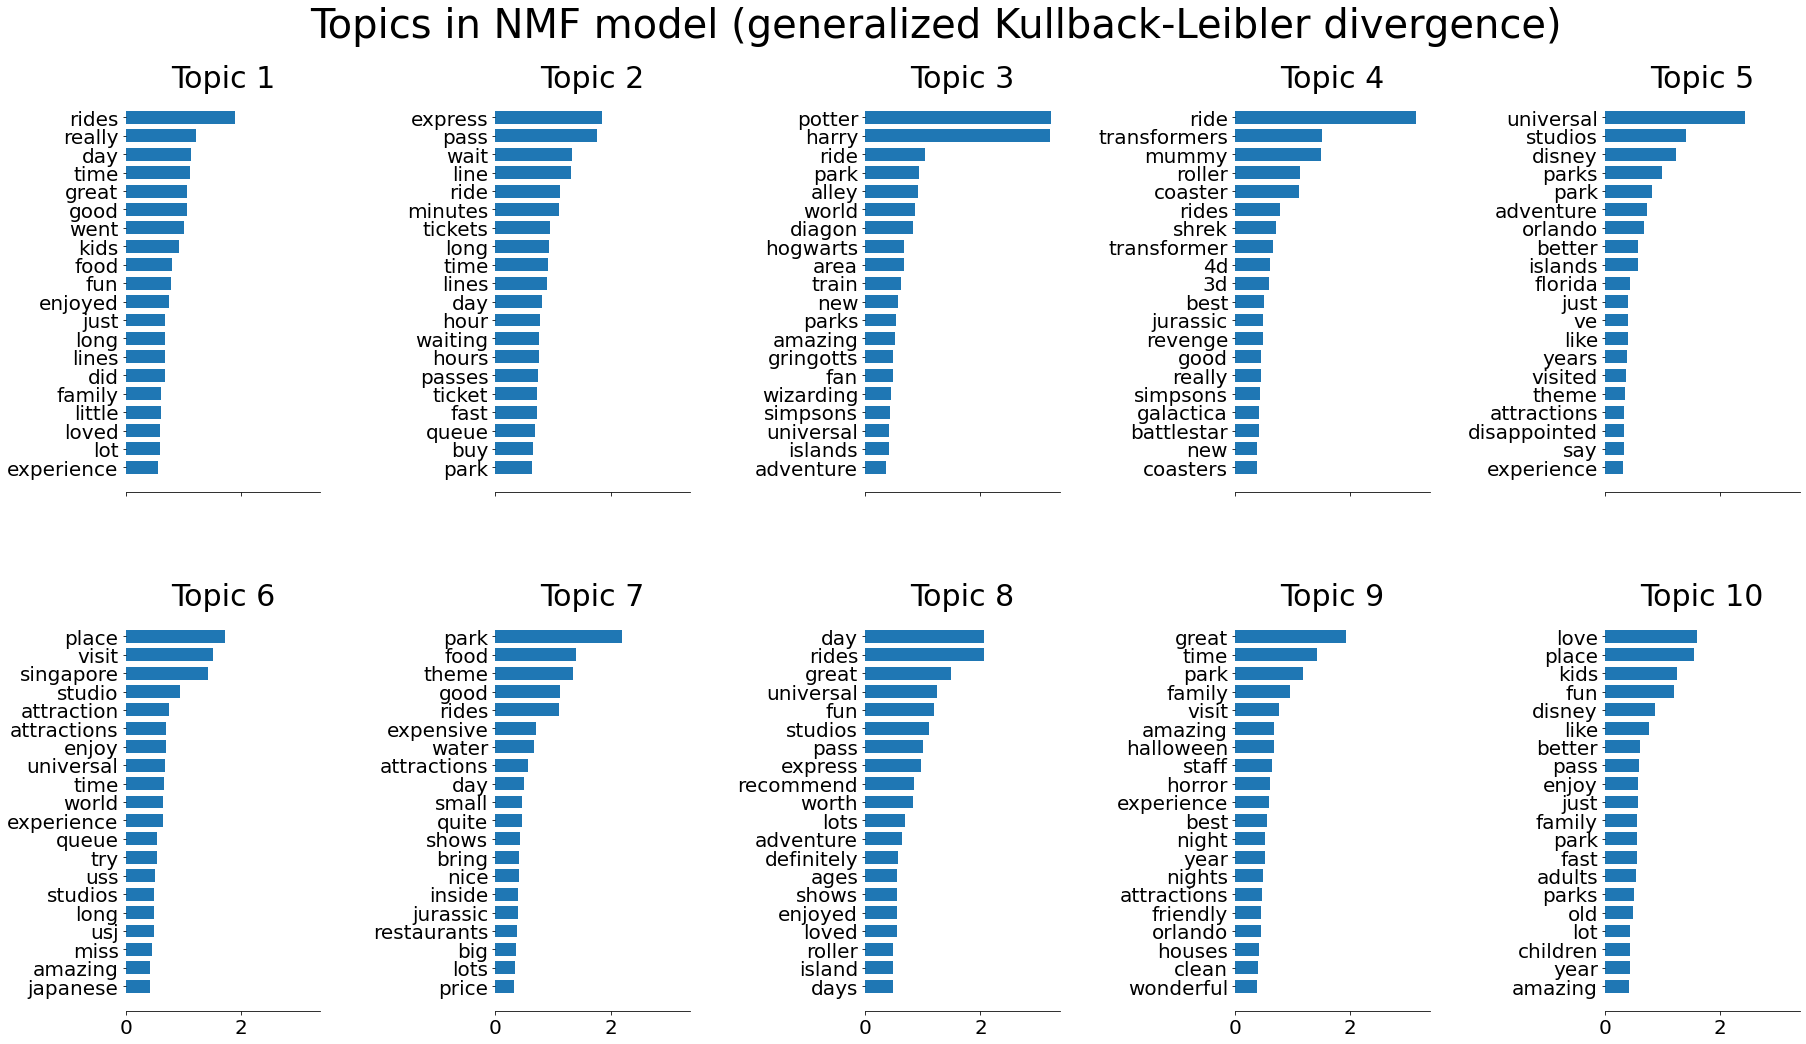



 Fitting LDA models with tf features, n_samples=50904 and n_features=1000...


In [95]:
# Fit the NMF model
print('\n' * 2, "Fitting the NMF model (generalized Kullback-Leibler "
      "divergence) with tf-idf features, n_samples=%d and n_features=%d..."
      % (n_samples, n_features))
t0 = time()
nmf = NMF(n_components=n_components, random_state=1,
          beta_loss='kullback-leibler', solver='mu', max_iter=1000, alpha=.1,
          l1_ratio=.5).fit(tfidf)
print("done in %0.3fs." % (time() - t0))

tfidf_feature_names = tfidf_vectorizer.get_feature_names()
plot_top_words(nmf, tfidf_feature_names, n_top_words,
               'Topics in NMF model (generalized Kullback-Leibler divergence)')

print('\n' * 2, "Fitting LDA models with tf features, "
      "n_samples=%d and n_features=%d..."
      % (n_samples, n_features))

In [96]:
def show_topics(vectorizer=tfidf_vectorizer, lda_model=nmf, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=tfidf_vectorizer, lda_model=nmf, n_words=20)  

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]

Topics_theme = ['Experience', 'Express Pass', 'Wizarding World', 'Rides', 'Florida', 
                'Japan/Singapore', 'Value', 'Recommend', 'Halloween Horror Night', 'Family/Age' ]

df_topic_keywords['topic_theme'] = Topics_theme
df_topic_keywords.set_index('topic_theme', inplace=True)
df_topic_keywords.T

topic_theme,Experience,Express Pass,Wizarding World,Rides,Florida,Japan/Singapore,Value,Recommend,Halloween Horror Night,Family/Age
Word 0,rides,express,potter,ride,universal,place,park,day,great,love
Word 1,really,pass,harry,transformers,studios,visit,food,rides,time,place
Word 2,day,wait,ride,mummy,disney,singapore,theme,great,park,kids
Word 3,time,line,park,roller,parks,studio,good,universal,family,fun
Word 4,great,ride,alley,coaster,park,attraction,rides,fun,visit,disney
Word 5,good,minutes,world,rides,adventure,attractions,expensive,studios,amazing,like
Word 6,went,tickets,diagon,shrek,orlando,enjoy,water,pass,halloween,better
Word 7,kids,long,hogwarts,transformer,better,universal,attractions,express,staff,pass
Word 8,food,time,area,4d,islands,time,day,recommend,horror,enjoy
Word 9,fun,lines,train,3d,florida,world,small,worth,experience,just


In [97]:
# Create Document - Topic Matrix
lda_output = nmf.transform(tfidf)

# column names
topicnames = df_topic_keywords.T.columns
# topicnames = ["Topic" + str(i) for i in range(20)]

# index names
docnames = ["Doc" + str(i) for i in range(len(corpus2))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

df_document_topic

topic_theme,Experience,Express Pass,Wizarding World,Rides,Florida,Japan/Singapore,Value,Recommend,Halloween Horror Night,Family/Age,dominant_topic
Doc0,0.00,0.06,0.01,0.00,0.03,0.00,0.00,0.0,0.00,0.00,1
Doc1,0.00,0.02,0.00,0.00,0.02,0.01,0.01,0.0,0.01,0.00,1
Doc2,0.01,0.02,0.00,0.00,0.09,0.00,0.00,0.0,0.00,0.00,4
Doc3,0.00,0.03,0.00,0.02,0.02,0.00,0.00,0.0,0.00,0.00,1
Doc4,0.00,0.02,0.00,0.00,0.02,0.03,0.00,0.0,0.03,0.00,5
...,...,...,...,...,...,...,...,...,...,...,...
Doc50899,0.02,0.03,0.00,0.01,0.02,0.00,0.05,0.0,0.02,0.00,6
Doc50900,0.01,0.00,0.00,0.10,0.04,0.03,0.01,0.0,0.00,0.00,3
Doc50901,0.04,0.02,0.00,0.01,0.01,0.00,0.02,0.0,0.00,0.00,0
Doc50902,0.03,0.01,0.00,0.00,0.01,0.00,0.06,0.0,0.01,0.00,6


In [98]:
df_document_topic.reset_index(inplace=True)
df_sent_topic= pd.merge(corpus2, df_document_topic, left_index=True, right_index=True)
df_sent_topic.drop('index', axis=1, inplace=True)
df_sent_topic

,review_text,Experience,Express Pass,Wizarding World,Rides,Florida,Japan/Singapore,Value,Recommend,Halloween Horror Night,Family/Age,dominant_topic
0,We went to Universal over Memorial Day weekend...,0.00,0.06,0.01,0.00,0.03,0.00,0.00,0.0,0.00,0.00,1
1,The food service is horrible. I’m not reviewin...,0.00,0.02,0.00,0.00,0.02,0.01,0.01,0.0,0.01,0.00,1
2,I booked this vacation mainly to ride Hagrid m...,0.01,0.02,0.00,0.00,0.09,0.00,0.00,0.0,0.00,0.00,4
3,When a person tries the test seat for the ride...,0.00,0.03,0.00,0.02,0.02,0.00,0.00,0.0,0.00,0.00,1
4,"Ok, I can't stress enough to anyone and everyo...",0.00,0.02,0.00,0.00,0.02,0.03,0.00,0.0,0.03,0.00,5
...,...,...,...,...,...,...,...,...,...,...,...,...
50899,This is my first visit to a Universal Studio t...,0.02,0.03,0.00,0.01,0.02,0.00,0.05,0.0,0.02,0.00,6
50900,We finally visited Singapore's very first them...,0.01,0.00,0.00,0.10,0.04,0.03,0.01,0.0,0.00,0.00,3
50901,We visited during the first week of its 'soft ...,0.04,0.02,0.00,0.01,0.01,0.00,0.02,0.0,0.00,0.00,0
50902,We visited on the 3rd day of the 'soft' openin...,0.03,0.01,0.00,0.00,0.01,0.00,0.06,0.0,0.01,0.00,6


In [99]:
df_topic_theme = df_sent_topic[['review_text', 'dominant_topic']]
df_topic_theme.head(10)

,review_text,dominant_topic
0,We went to Universal over Memorial Day weekend...,1
1,The food service is horrible. I’m not reviewin...,1
2,I booked this vacation mainly to ride Hagrid m...,4
3,When a person tries the test seat for the ride...,1
4,"Ok, I can't stress enough to anyone and everyo...",5
5,Worst experience I have ever had the rides are...,4
6,"I just expected more. Alot of waiting around, ...",4
7,This was my 4th trip with my daughter to Unive...,0
8,Universal is one thing - Not Disney. Everythin...,4
9,We spent 6 nights on site at Sapphire Falls as...,0


In [100]:
def label_theme(row):
    if row['dominant_topic'] == 0 :
        return 'Experience'
    if row['dominant_topic'] == 1 :
        return 'Express Pass'
    if row['dominant_topic'] == 2 :
        return 'Wizarding World'
    if row['dominant_topic'] == 3:
        return 'Rides'
    if row['dominant_topic']  == 4:
        return 'Florida'
    if row['dominant_topic'] == 5:
        return 'Japan/Singapore'
    if row['dominant_topic'] == 6:
        return 'Value'
    if row['dominant_topic'] == 7:
        return 'Recommend'
    if row['dominant_topic'] == 8:
        return 'Halloween Horror Nights'
    if row['dominant_topic'] == 9:
        return 'Family/Age'

df_topic_theme['dominant_topic_theme'] = df_topic_theme.apply (lambda row: label_theme(row), axis=1)


df_topic_theme.tail(15)

<ipython-input-100-02c35e5f51c1>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_topic_theme['dominant_topic_theme'] = df_topic_theme.apply (lambda row: label_theme(row), axis=1)


,review_text,dominant_topic,dominant_topic_theme
50889,The Universal Studios in Singapore almost repl...,6,Value
50890,We went May 12th with the family. Adults were ...,0,Experience
50891,We went Universal Studio on Monday 3rd May. I ...,3,Rides
50892,Ticket to enter the park costs SGD66.00 which ...,3,Rides
50893,"Upon our entry, we decided to head around the ...",3,Rides
50894,While what they have got so far looks like it ...,6,Value
50895,I expected Universal Studios Singapore to be i...,3,Rides
50896,most of the rides are functional except for th...,1,Express Pass
50897,"We went on a Thursday, and hardly had to wait ...",3,Rides
50898,Two kids (7+10) and two adults went to Univers...,1,Express Pass


In [101]:
df_topic_theme['dominant_topic_theme'].value_counts()         

Express Pass               7917
Experience                 6931
Wizarding World            6029
Rides                      5602
Florida                    4876
Japan/Singapore            4553
Value                      4436
Halloween Horror Nights    4062
Recommend                  3346
Family/Age                 3152
Name: dominant_topic_theme, dtype: int64

In [102]:
result = pd.concat([df_topic_theme, y], axis=1, join="inner")
result

,review_text,dominant_topic,dominant_topic_theme,rating
0,We went to Universal over Memorial Day weekend...,1,Express Pass,2.0
1,The food service is horrible. I’m not reviewin...,1,Express Pass,1.0
2,I booked this vacation mainly to ride Hagrid m...,4,Florida,2.0
3,When a person tries the test seat for the ride...,1,Express Pass,4.0
4,"Ok, I can't stress enough to anyone and everyo...",5,Japan/Singapore,5.0
...,...,...,...,...
50899,This is my first visit to a Universal Studio t...,6,Value,4.0
50900,We finally visited Singapore's very first them...,3,Rides,4.0
50901,We visited during the first week of its 'soft ...,0,Experience,4.0
50902,We visited on the 3rd day of the 'soft' openin...,6,Value,4.0


<AxesSubplot:xlabel='dominant_topic_theme', ylabel='count'>

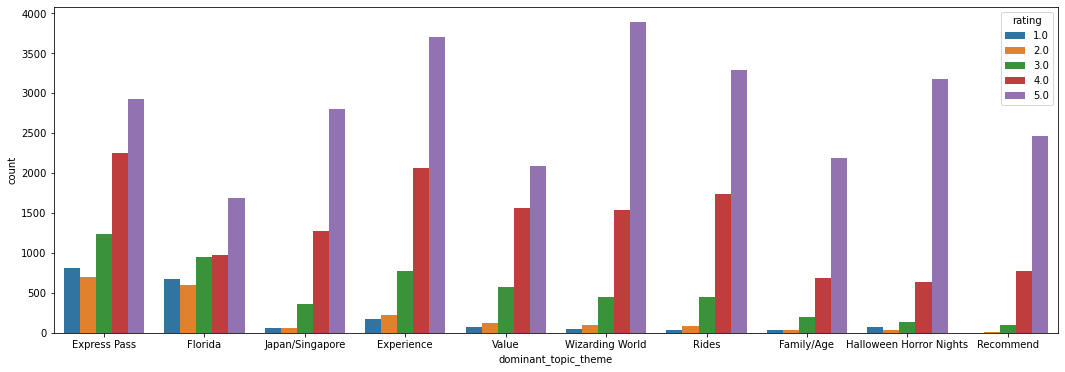

In [103]:
fig, ax = plt.subplots(figsize=(18,6))
sns.countplot(data=result, x='dominant_topic_theme', hue='rating', ax=ax)